In [1]:
'''
def get_StratifiedShuffleSplit(batches_idx,batch_size):
    n_bins  = 5
    batch_size = 5*7*7
    y_classes = df['steering'].copy()*n_bins//1
    batches_idx = df.index
    data_size = len(batches_idx)
    n_split = int(data_size//batch_size)-1
    print(n_split)
    batch_range = df.index
    sss = StratifiedShuffleSplit(n_splits = n_split,test_size = 15)
    batch_idx, val_idx = next(sss.split((batch_range),(y_classes.values)))
    
    batch_idx = batch_idx[:batch_size*n_split].reshape((n_split,batch_size, ))
    batch_idx = batch_idx[:batch_size*n_split].reshape((n_split,batch_size, ))
    
    return batch_idx, val_idx

    batch_idx, val_idx = (get_batch_idx(batches_idx,batch_size = 256))
    batch_idx.shape
    
    #from keras.layers.recurrent import LSTM, GRU, SimpleRNN
#from keras.layers.wrappers import TimeDistributed
#from keras.regularizers import l2, activity_l2


'''

"\ndef get_StratifiedShuffleSplit(batches_idx,batch_size):\n    n_bins  = 5\n    batch_size = 5*7*7\n    y_classes = df['steering'].copy()*n_bins//1\n    batches_idx = df.index\n    data_size = len(batches_idx)\n    n_split = int(data_size//batch_size)-1\n    print(n_split)\n    batch_range = df.index\n    sss = StratifiedShuffleSplit(n_splits = n_split,test_size = 15)\n    batch_idx, val_idx = next(sss.split((batch_range),(y_classes.values)))\n    \n    batch_idx = batch_idx[:batch_size*n_split].reshape((n_split,batch_size, ))\n    batch_idx = batch_idx[:batch_size*n_split].reshape((n_split,batch_size, ))\n    \n    return batch_idx, val_idx\n\n    batch_idx, val_idx = (get_batch_idx(batches_idx,batch_size = 256))\n    batch_idx.shape\n    \n    #from keras.layers.recurrent import LSTM, GRU, SimpleRNN\n#from keras.layers.wrappers import TimeDistributed\n#from keras.regularizers import l2, activity_l2\n\n\n"

In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

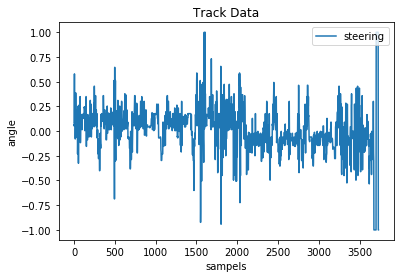

(3732, 8)


In [3]:
# read csv
def get_csv(path):
    # load CSV & drop zeros
    df = pd.read_csv(path+'driving_log.csv')
    df = df.drop(df[df['steering'] == 0.].index)
    df = df.drop(df[df['speed'] < 1.].index)
    df['center'] = path+df['center']
    df['right'] = path+df['right']
    df['left'] = path+df['left']
    return df

tracks = [get_csv(path = './data/'),\
          #get_csv(path = './andy_track1_forward/'),\
          #get_csv(path = './andy_track1_backward/'),\
          get_csv(path = './andy_track1_offroad/'),\
          #get_csv(path = './andy_track1_offroad/'),\
          #get_csv(path = './andy_track1_offroad/'),\
         ]
df = pd.concat(tracks).reset_index()

def plot_steering(df):
    ### plot 
    plt.plot(df['steering'])
    plt.title('Track Data')
    plt.ylabel('angle')
    plt.xlabel('sampels')
    plt.legend(['steering'], loc='upper right')
    #plt.yscale('log')
    plt.show()
    
plot_steering(df)
print(df.shape)

In [4]:
# split
split_index = int((1-(1/11))*(len(df)))
df_train = df[:split_index]
df_val  = df[split_index:]

In [5]:
# argumentation and batching parameters:
image_shape = (160,320,3) #cv2.imread( df['center'][df['center'].index[0]]).shape

steering_argumentation_offset = .3
steering_scale = 1.1

batch_size_single = 8

In [6]:
##### generate argumentated batch

from sklearn.utils import shuffle

def get_batch(df,batch_size_single): 
    n_split = int(len(df)//batch_size_single)-1
    batch_idx = (df[:batch_size_single*n_split].index.values)   
    batch_idx = shuffle(batch_idx)
    batch_idx = batch_idx.reshape(n_split,batch_size_single,)
    while 1:
        batch_y            = np.empty(list([batch_size_single*6]))
        batch_x            = np.empty(list([batch_size_single*6]) + list(image_shape))
        for idxes in batch_idx:
            inc = 0
            for idx in idxes:
                batch_y[0+inc]      =  (steering_scale*df['steering'][idx] + steering_argumentation_offset) 
                batch_y[1+inc]      = -(steering_scale*df['steering'][idx] + steering_argumentation_offset) 
                batch_y[2+inc]      =  (steering_scale*df['steering'][idx] - steering_argumentation_offset) 
                batch_y[3+inc]      = -(steering_scale*df['steering'][idx] - steering_argumentation_offset) 
                batch_y[4+inc]      =  (df['steering'][idx]) 
                batch_y[5+inc]      = -(df['steering'][idx]) 
                batch_x[0+inc]      = cv2.imread(df['left'][idx]) 
                batch_x[1+inc]      = cv2.imread(df['left'][idx])[:,-1::-1]
                batch_x[2+inc]      = cv2.imread(df['right'][idx])  
                batch_x[3+inc]      = cv2.imread(df['right'][idx])[:,-1::-1]
                batch_x[4+inc]      = cv2.imread(df['center'][idx])  
                batch_x[5+inc]      = cv2.imread(df['center'][idx])[:,-1::-1]
                inc += 6
            assert(not(np.isnan((np.sum(batch_x)))))
            assert(not(np.isnan((np.sum(batch_y)))))
            #yield (batch_x,batch_y)             
            yield shuffle(batch_x,batch_y) 

train_generator = get_batch(df_train, batch_size_single=batch_size_single)
validation_generator = get_batch(df_val, batch_size_single=batch_size_single)

(48, 160, 320, 3)


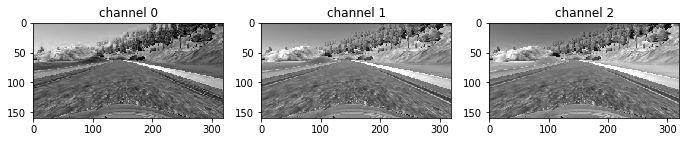

steering: -0.04076847, idx: 0


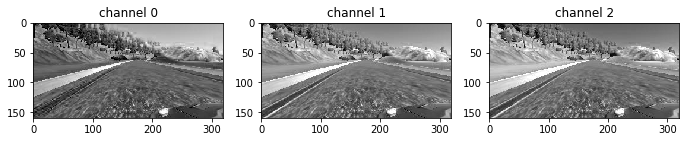

steering: 0.344845317, idx: 8


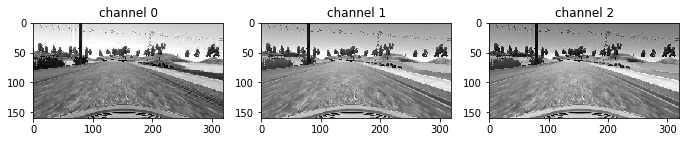

steering: -0.05026283, idx: 16


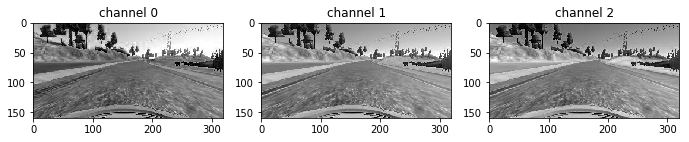

steering: 0.1191711, idx: 24


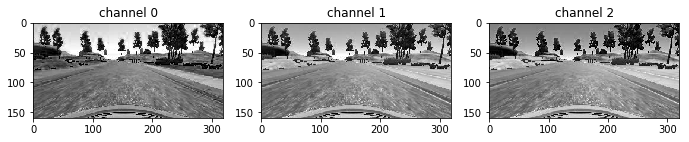

steering: -0.05975719, idx: 32


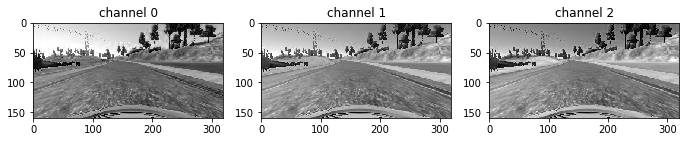

steering: -0.1191711, idx: 40
Wall time: 7.98 s


In [7]:
def visualise_dataset(image,label,steps):
    plt_num = 1
    print(image.shape)
    step_size = int(image.shape[0]/steps)
    for image_idx in range(0,image.shape[0],step_size):
        channels = image.shape[3]
        plt.figure(plt_num, figsize=(32,32))
        for channel in range(channels):
            plt.subplot(4,8, channel+1) # sets the number of feature maps to show on each row and column
            plt.title('channel ' + str(channel)) # displays the feature map number
            plt.imshow(image[image_idx,:,:, channel], interpolation="nearest", cmap="gray") # cmap="gist_earth_r"
        plt.show()
        print('steering: {1}, idx: {0}'.format(image_idx,label[image_idx],))

batch_x,batch_y = next(train_generator)
%time visualise_dataset(batch_x,batch_y,steps=6)

In [ ]:
import matplotlib

def plot_history_object(history_object):
    ### print the keys contained in the history object
    print(history_object.history.keys())

    ### plot the training and validation loss for each epoch
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.yscale('log')
    plt.show()


Using TensorFlow backend.


nb_epoch   	:   466
batch_size 	:    48
patience   	:  5000
load_weights done
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_1 (Cropping2D)        (None, 72, 320, 3)    0           cropping2d_input_1[0][0]         
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 72, 320, 3)    0           cropping2d_1[0][0]               
____________________________________________________________________________________________________
reshape_1 (Reshape)              (None, 144, 160, 3)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 72, 80, 16)    3904        reshape_1[0][0]                  
_____________

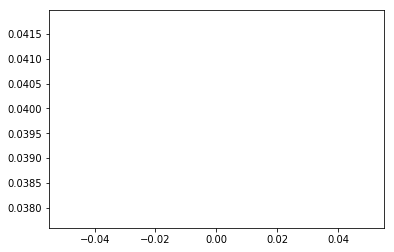

288/288 [==============================] - 36s - loss: 0.0398 - val_loss: 0.1748
Epoch 2/466
240/288 [========================>.....] - ETA: 5s - loss: 0.0408 

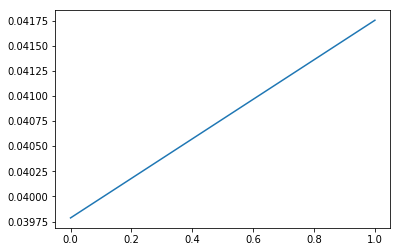

288/288 [==============================] - 34s - loss: 0.0418 - val_loss: 0.0492
Epoch 3/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0317

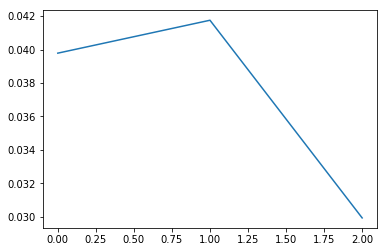

288/288 [==============================] - 33s - loss: 0.0299 - val_loss: 0.2761
Epoch 4/466
240/288 [========================>.....] - ETA: 5s - loss: 0.0294 

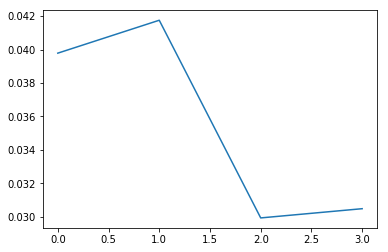

288/288 [==============================] - 34s - loss: 0.0305 - val_loss: 0.1237
Epoch 5/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0516

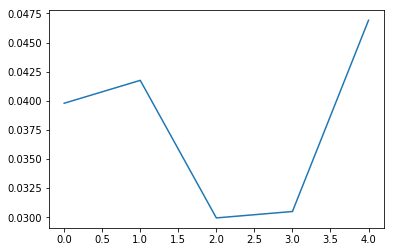

288/288 [==============================] - 33s - loss: 0.0469 - val_loss: 0.1061
Epoch 6/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0626

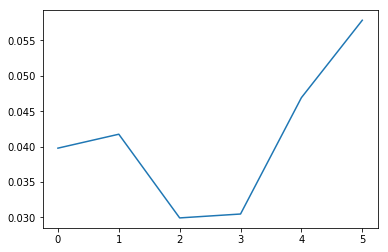

288/288 [==============================] - 32s - loss: 0.0578 - val_loss: 0.0683
Epoch 7/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0465

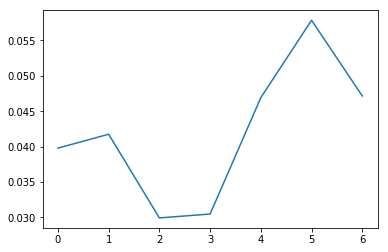

288/288 [==============================] - 32s - loss: 0.0472 - val_loss: 0.0483
Epoch 8/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0425

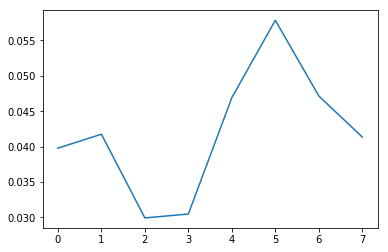

288/288 [==============================] - 31s - loss: 0.0414 - val_loss: 0.2196
Epoch 9/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0282

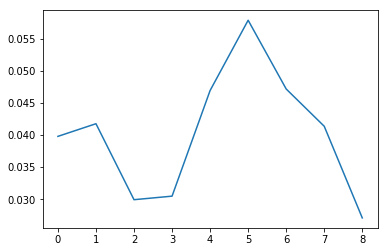

288/288 [==============================] - 31s - loss: 0.0271 - val_loss: 0.1543
Epoch 10/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0658

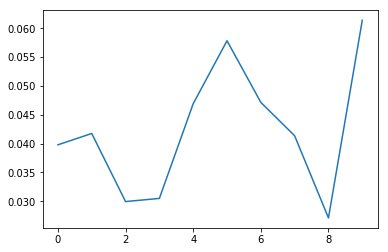

288/288 [==============================] - 31s - loss: 0.0614 - val_loss: 0.1874
Epoch 11/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0509

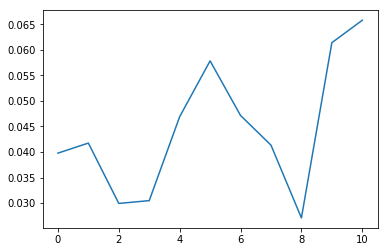

288/288 [==============================] - 33s - loss: 0.0658 - val_loss: 0.1763
Epoch 12/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0420

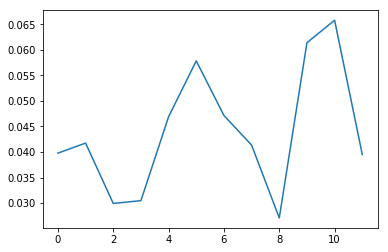

288/288 [==============================] - 31s - loss: 0.0395 - val_loss: 0.0566
Epoch 13/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0234

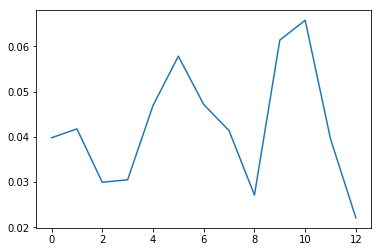

288/288 [==============================] - 31s - loss: 0.0221 - val_loss: 0.1719
Epoch 14/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0313

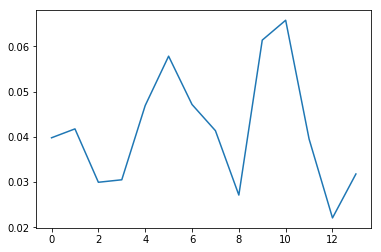

288/288 [==============================] - 31s - loss: 0.0318 - val_loss: 0.1651
Epoch 15/466
240/288 [========================>.....] - ETA: 5s - loss: 0.0410 

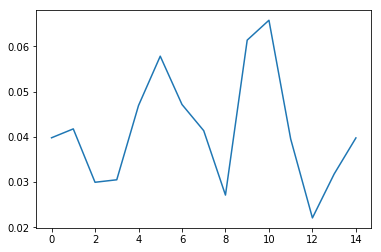

288/288 [==============================] - 33s - loss: 0.0398 - val_loss: 0.2236
Epoch 16/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0328

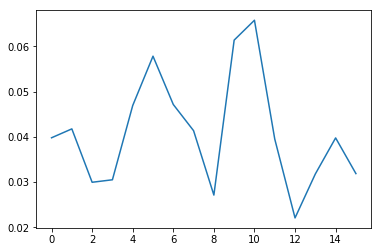

288/288 [==============================] - 31s - loss: 0.0319 - val_loss: 0.1833
Epoch 17/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0287

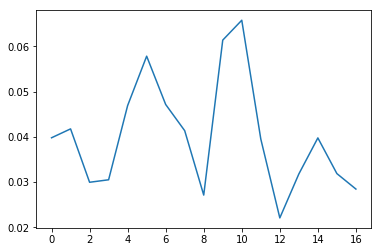

288/288 [==============================] - 31s - loss: 0.0284 - val_loss: 0.1524
Epoch 18/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0304

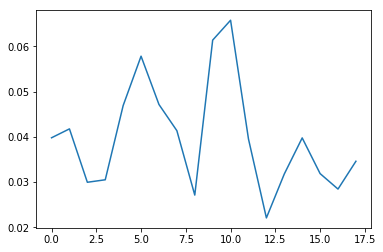

288/288 [==============================] - 31s - loss: 0.0346 - val_loss: 0.0881
Epoch 19/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0461

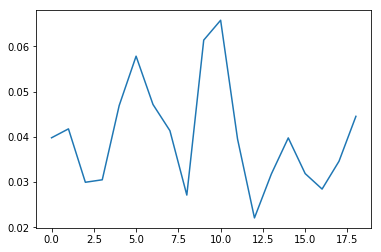

288/288 [==============================] - 31s - loss: 0.0445 - val_loss: 0.1209
Epoch 20/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0310

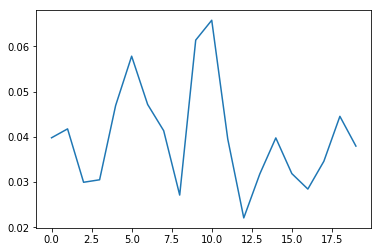

288/288 [==============================] - 30s - loss: 0.0379 - val_loss: 0.0861
Epoch 21/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0384

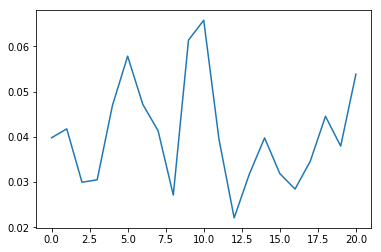

288/288 [==============================] - 31s - loss: 0.0539 - val_loss: 0.3520
Epoch 22/466
240/288 [========================>.....] - ETA: 5s - loss: 0.0576

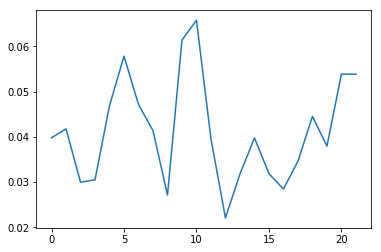

288/288 [==============================] - 34s - loss: 0.0538 - val_loss: 0.1326
Epoch 23/466
240/288 [========================>.....] - ETA: 5s - loss: 0.0368 

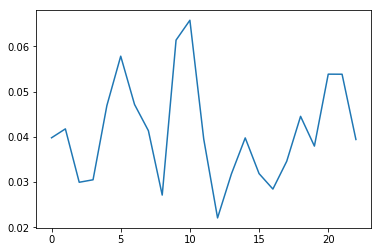

288/288 [==============================] - 35s - loss: 0.0394 - val_loss: 0.0555
Epoch 24/466
240/288 [========================>.....] - ETA: 5s - loss: 0.0394 

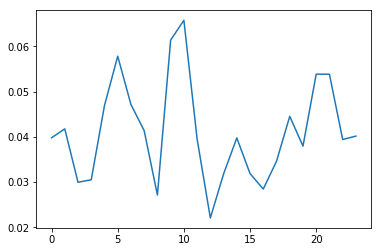

288/288 [==============================] - 37s - loss: 0.0402 - val_loss: 0.0472
Epoch 25/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0263

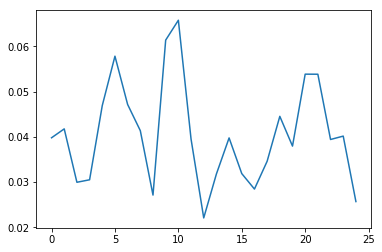

288/288 [==============================] - 33s - loss: 0.0257 - val_loss: 0.1425
Epoch 26/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0242

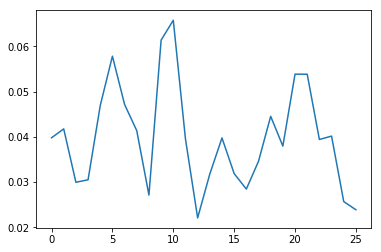

288/288 [==============================] - 32s - loss: 0.0239 - val_loss: 0.0377
Epoch 27/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0329

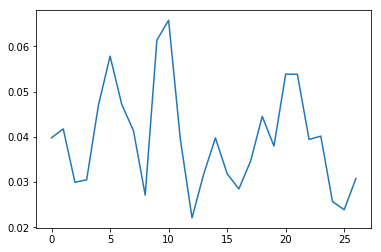

288/288 [==============================] - 31s - loss: 0.0308 - val_loss: 0.1168
Epoch 28/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0291

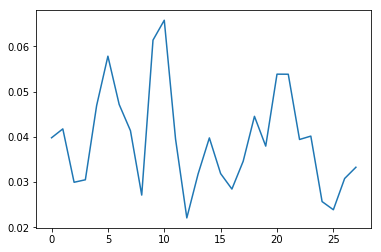

288/288 [==============================] - 32s - loss: 0.0333 - val_loss: 0.2211
Epoch 29/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0292

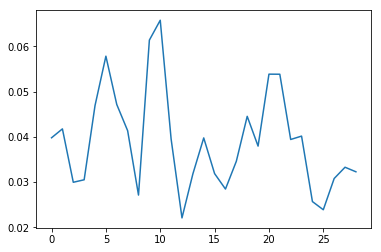

288/288 [==============================] - 31s - loss: 0.0323 - val_loss: 0.1266
Epoch 30/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0355

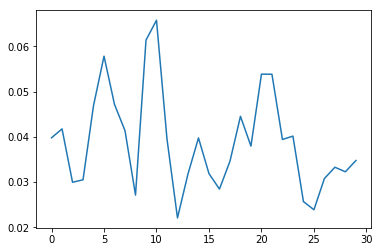

288/288 [==============================] - 32s - loss: 0.0348 - val_loss: 0.1345
Epoch 31/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0455

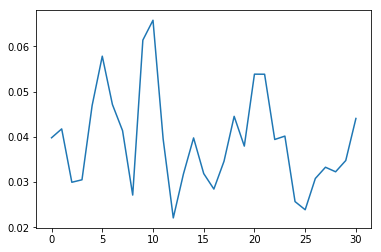

288/288 [==============================] - 32s - loss: 0.0441 - val_loss: 0.1954
Epoch 32/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0315

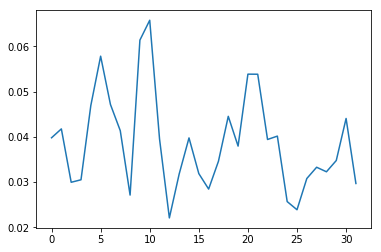

288/288 [==============================] - 32s - loss: 0.0297 - val_loss: 0.0483
Epoch 33/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0497

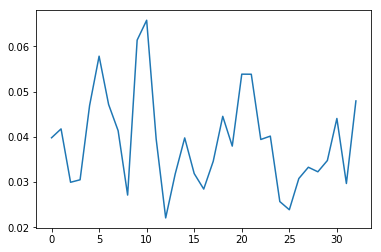

288/288 [==============================] - 35s - loss: 0.0479 - val_loss: 0.2286
Epoch 34/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0481

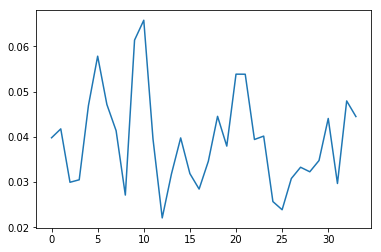

288/288 [==============================] - 33s - loss: 0.0445 - val_loss: 0.2131
Epoch 35/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0355

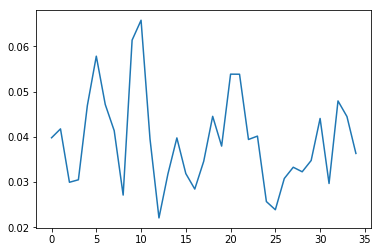

288/288 [==============================] - 31s - loss: 0.0363 - val_loss: 0.2870
Epoch 36/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0395

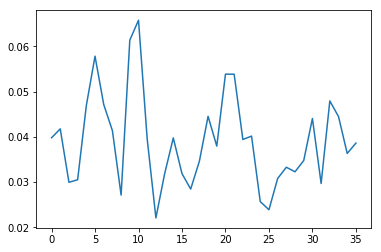

288/288 [==============================] - 31s - loss: 0.0386 - val_loss: 0.2878
Epoch 37/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0299

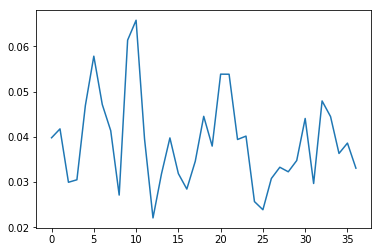

288/288 [==============================] - 32s - loss: 0.0331 - val_loss: 0.1266
Epoch 38/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0523

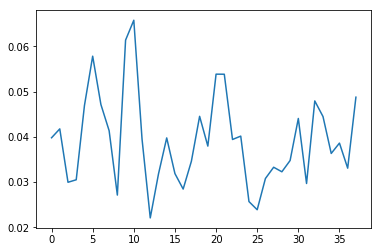

288/288 [==============================] - 32s - loss: 0.0488 - val_loss: 0.1075
Epoch 39/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0334

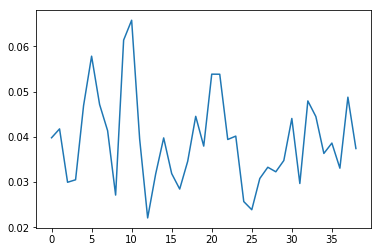

288/288 [==============================] - 31s - loss: 0.0374 - val_loss: 0.0794
Epoch 40/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0418

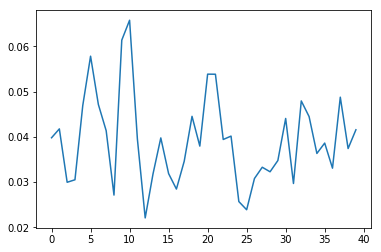

288/288 [==============================] - 31s - loss: 0.0416 - val_loss: 0.0335
Epoch 41/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0508

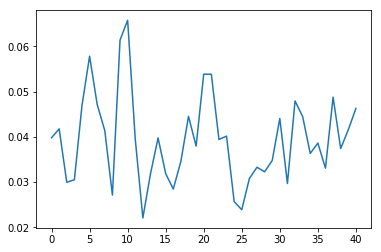

288/288 [==============================] - 32s - loss: 0.0463 - val_loss: 0.3000
Epoch 42/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0283

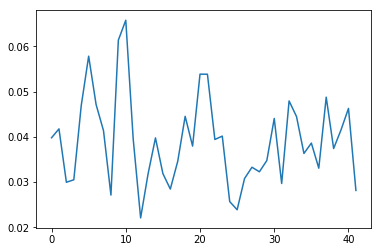

288/288 [==============================] - 32s - loss: 0.0281 - val_loss: 0.1480
Epoch 43/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0427

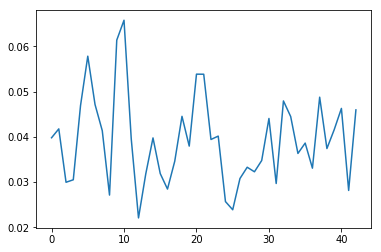

288/288 [==============================] - 32s - loss: 0.0460 - val_loss: 0.1826
Epoch 44/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0313

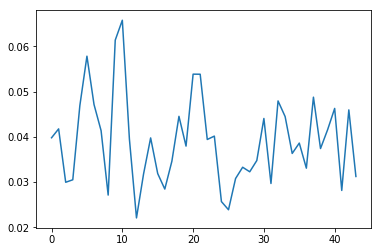

288/288 [==============================] - 31s - loss: 0.0312 - val_loss: 0.0489
Epoch 45/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0402

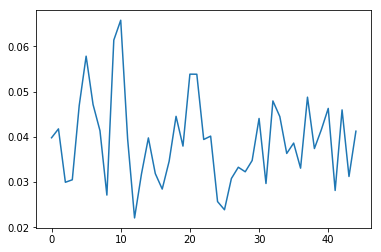

288/288 [==============================] - 31s - loss: 0.0412 - val_loss: 0.1582
Epoch 46/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0463

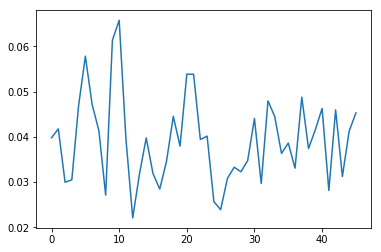

288/288 [==============================] - 31s - loss: 0.0453 - val_loss: 0.1687
Epoch 47/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0250

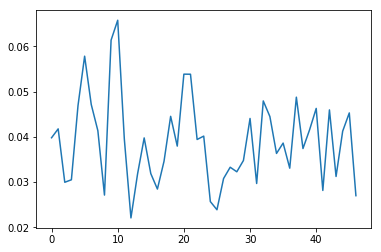

288/288 [==============================] - 30s - loss: 0.0270 - val_loss: 0.2163
Epoch 48/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0394

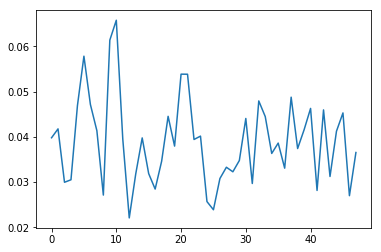

288/288 [==============================] - 32s - loss: 0.0365 - val_loss: 0.1300
Epoch 49/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0356

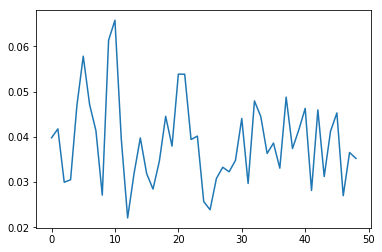

288/288 [==============================] - 32s - loss: 0.0352 - val_loss: 0.1018
Epoch 50/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0454

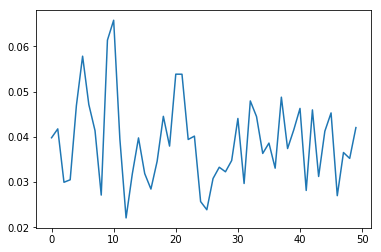

288/288 [==============================] - 31s - loss: 0.0420 - val_loss: 0.0679
Epoch 51/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0446

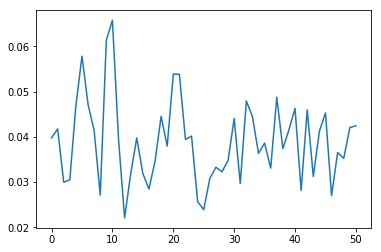

288/288 [==============================] - 31s - loss: 0.0424 - val_loss: 0.0855
Epoch 52/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0344

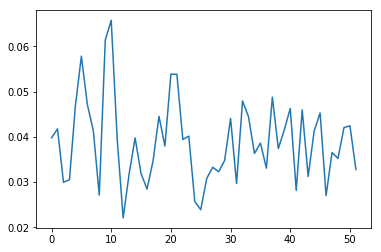

288/288 [==============================] - 31s - loss: 0.0328 - val_loss: 0.0525
Epoch 53/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0300

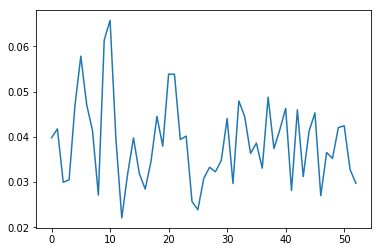

288/288 [==============================] - 29s - loss: 0.0297 - val_loss: 0.2720
Epoch 54/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0378

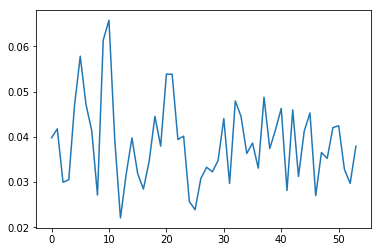

288/288 [==============================] - 30s - loss: 0.0379 - val_loss: 0.1174
Epoch 55/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0418

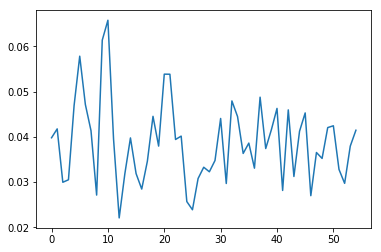

288/288 [==============================] - 29s - loss: 0.0415 - val_loss: 0.0632
Epoch 56/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0374

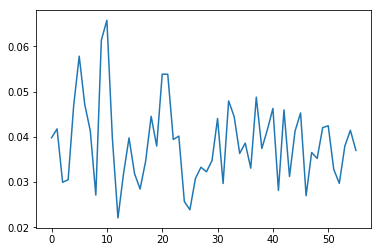

288/288 [==============================] - 30s - loss: 0.0370 - val_loss: 0.1279
Epoch 57/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0332

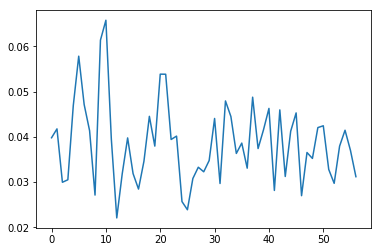

288/288 [==============================] - 30s - loss: 0.0312 - val_loss: 0.0710
Epoch 58/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0285

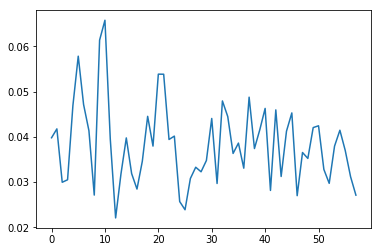

288/288 [==============================] - 29s - loss: 0.0271 - val_loss: 0.2395
Epoch 59/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0396

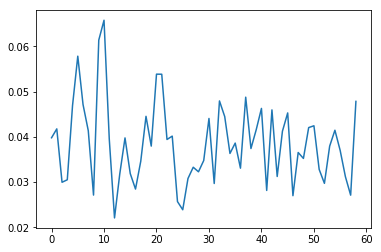

288/288 [==============================] - 30s - loss: 0.0478 - val_loss: 0.4405
Epoch 60/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0313

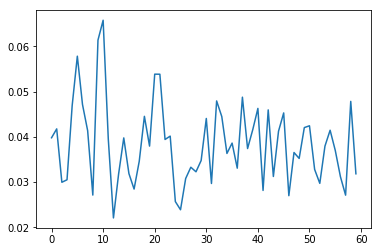

288/288 [==============================] - 30s - loss: 0.0318 - val_loss: 0.1273
Epoch 61/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0409

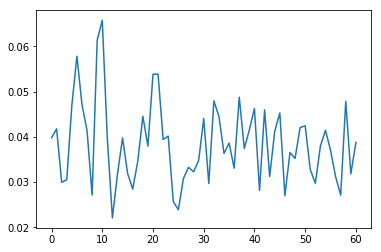

288/288 [==============================] - 31s - loss: 0.0387 - val_loss: 0.2914
Epoch 62/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0305

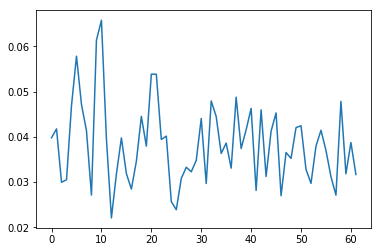

288/288 [==============================] - 30s - loss: 0.0317 - val_loss: 0.0673
Epoch 63/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0268

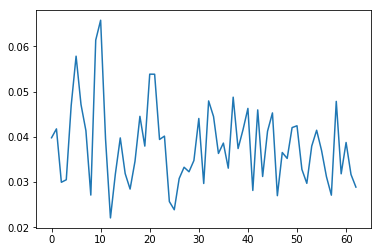

288/288 [==============================] - 31s - loss: 0.0289 - val_loss: 0.0937
Epoch 64/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0294

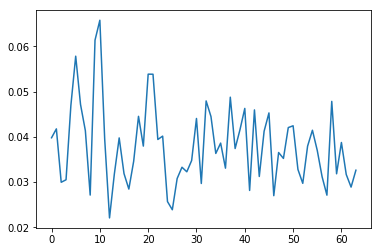

288/288 [==============================] - 34s - loss: 0.0326 - val_loss: 0.1238
Epoch 65/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0441

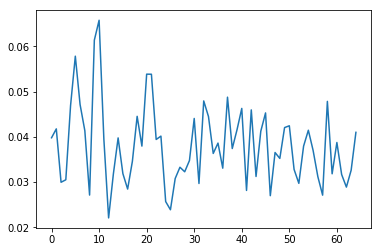

288/288 [==============================] - 31s - loss: 0.0410 - val_loss: 0.1691
Epoch 66/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0467

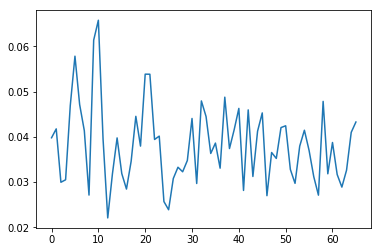

288/288 [==============================] - 31s - loss: 0.0433 - val_loss: 0.1833
Epoch 67/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0346

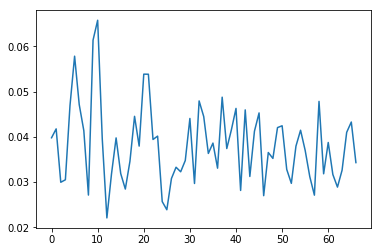

288/288 [==============================] - 31s - loss: 0.0343 - val_loss: 0.0622
Epoch 68/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0481

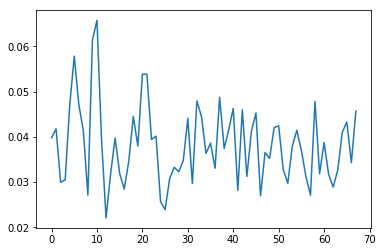

288/288 [==============================] - 31s - loss: 0.0457 - val_loss: 0.0734
Epoch 69/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0296

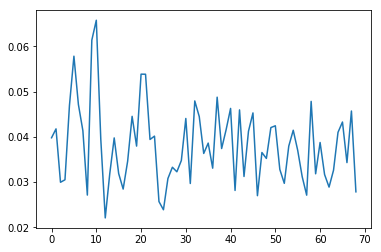

288/288 [==============================] - 31s - loss: 0.0278 - val_loss: 0.0979
Epoch 70/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0287

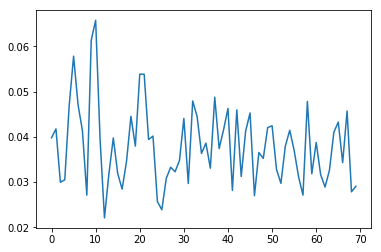

288/288 [==============================] - 31s - loss: 0.0291 - val_loss: 0.0688
Epoch 71/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0535

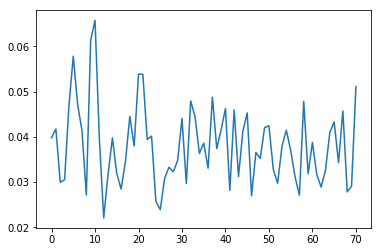

288/288 [==============================] - 30s - loss: 0.0511 - val_loss: 0.3296
Epoch 72/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0361

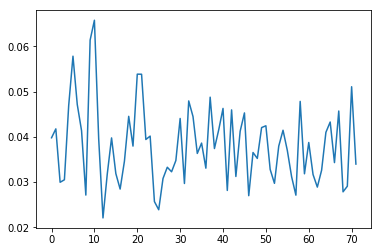

288/288 [==============================] - 30s - loss: 0.0340 - val_loss: 0.1236
Epoch 73/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0377

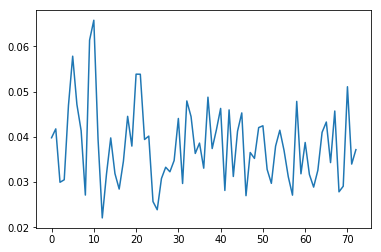

288/288 [==============================] - 31s - loss: 0.0372 - val_loss: 0.0586
Epoch 74/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0230

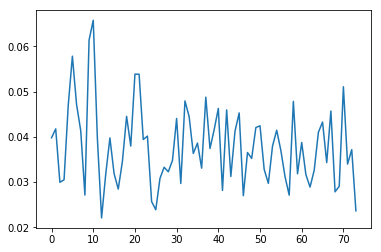

288/288 [==============================] - 31s - loss: 0.0236 - val_loss: 0.1231
Epoch 75/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0384

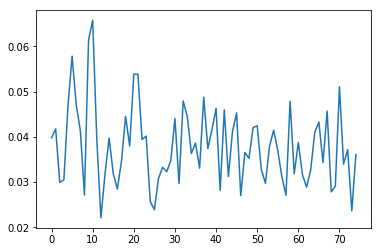

288/288 [==============================] - 31s - loss: 0.0361 - val_loss: 0.1677
Epoch 76/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0546

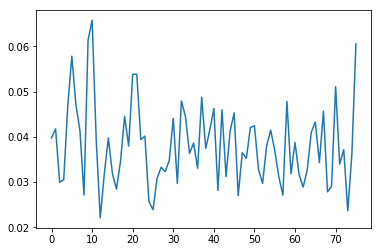

288/288 [==============================] - 31s - loss: 0.0605 - val_loss: 0.2046
Epoch 77/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0458

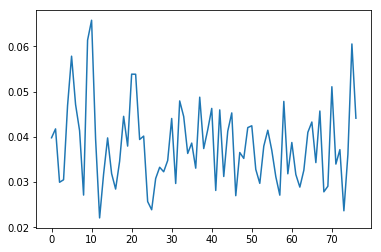

288/288 [==============================] - 29s - loss: 0.0441 - val_loss: 0.1593
Epoch 78/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0493

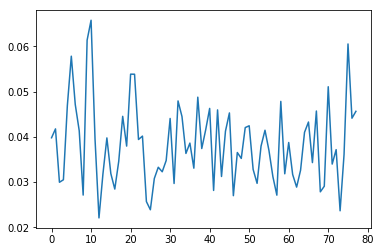

288/288 [==============================] - 29s - loss: 0.0456 - val_loss: 0.1117
Epoch 79/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0365

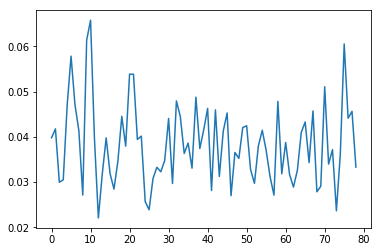

288/288 [==============================] - 29s - loss: 0.0333 - val_loss: 0.0646
Epoch 80/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0294

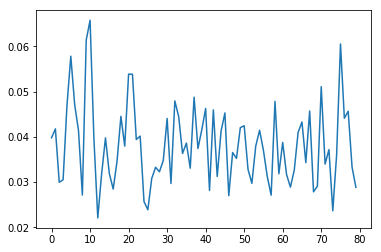

288/288 [==============================] - 30s - loss: 0.0288 - val_loss: 0.0999
Epoch 81/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0813

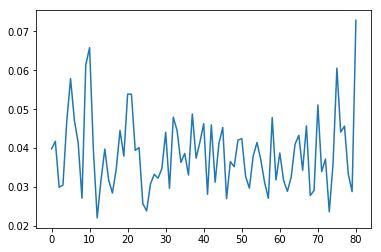

288/288 [==============================] - 29s - loss: 0.0729 - val_loss: 0.0556
Epoch 82/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0514

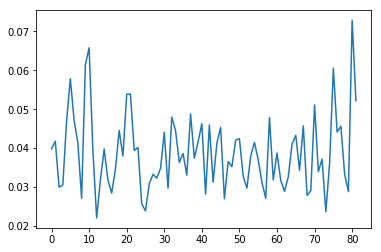

288/288 [==============================] - 30s - loss: 0.0522 - val_loss: 0.1578
Epoch 83/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0316

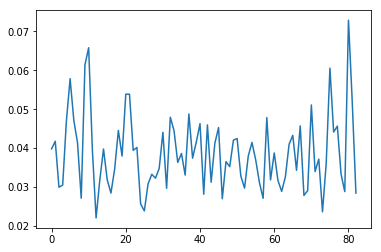

288/288 [==============================] - 29s - loss: 0.0284 - val_loss: 0.1758
Epoch 84/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0259

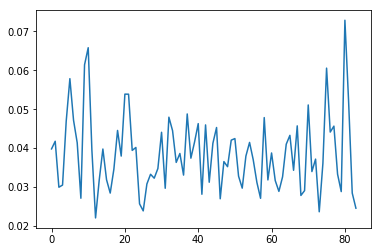

288/288 [==============================] - 30s - loss: 0.0245 - val_loss: 0.0412
Epoch 85/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0338

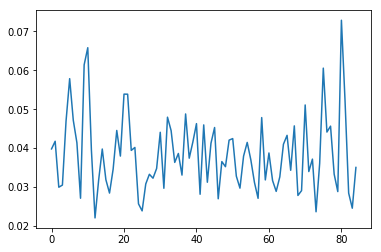

288/288 [==============================] - 29s - loss: 0.0350 - val_loss: 0.0715
Epoch 86/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0374

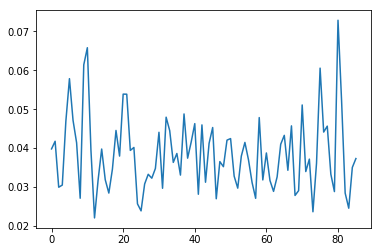

288/288 [==============================] - 30s - loss: 0.0373 - val_loss: 0.0677
Epoch 87/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0316

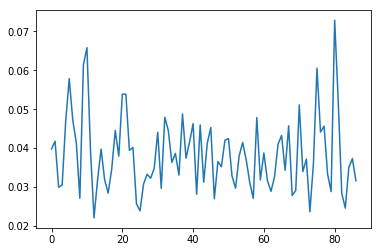

288/288 [==============================] - 31s - loss: 0.0316 - val_loss: 0.2676
Epoch 88/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0248

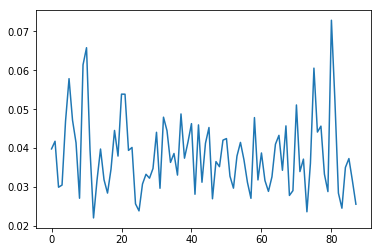

288/288 [==============================] - 29s - loss: 0.0256 - val_loss: 0.0593
Epoch 89/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0340

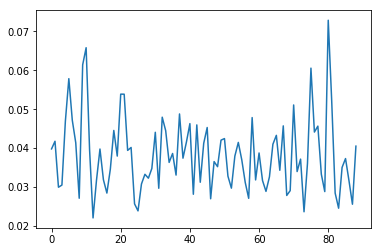

288/288 [==============================] - 30s - loss: 0.0405 - val_loss: 0.1220
Epoch 90/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0303

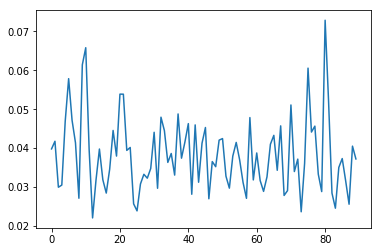

288/288 [==============================] - 30s - loss: 0.0372 - val_loss: 0.1384
Epoch 91/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0387

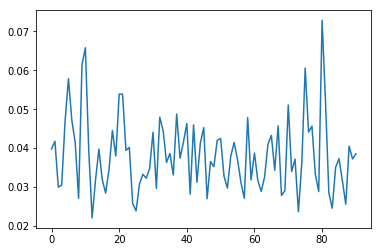

288/288 [==============================] - 29s - loss: 0.0385 - val_loss: 0.0699
Epoch 92/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0600

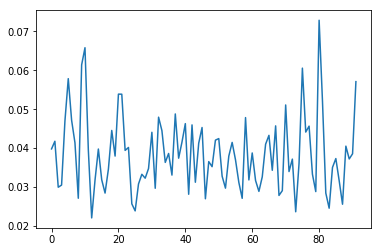

288/288 [==============================] - 33s - loss: 0.0571 - val_loss: 0.2184
Epoch 93/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0538

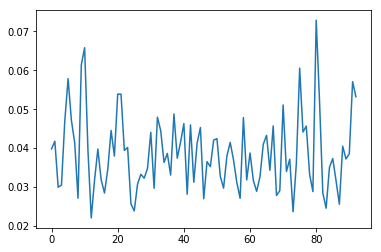

288/288 [==============================] - 31s - loss: 0.0532 - val_loss: 0.1828
Epoch 94/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0375

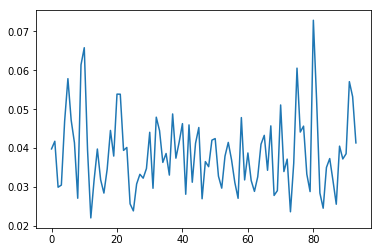

288/288 [==============================] - 31s - loss: 0.0413 - val_loss: 0.1164
Epoch 95/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0304

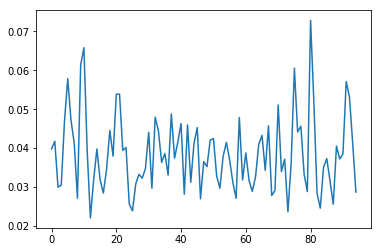

288/288 [==============================] - 31s - loss: 0.0287 - val_loss: 0.0949
Epoch 96/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0261

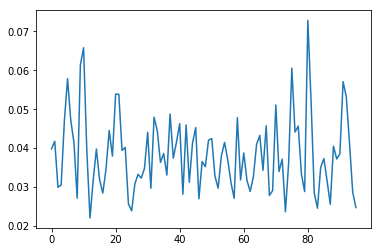

288/288 [==============================] - 30s - loss: 0.0247 - val_loss: 0.0379
Epoch 97/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0231

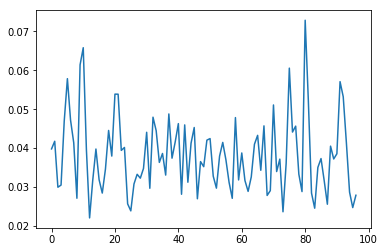

288/288 [==============================] - 30s - loss: 0.0279 - val_loss: 0.2979
Epoch 98/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0292

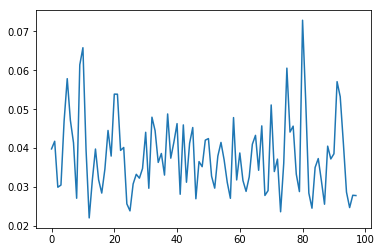

288/288 [==============================] - 29s - loss: 0.0278 - val_loss: 0.1435
Epoch 99/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0314

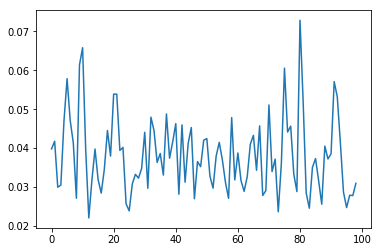

288/288 [==============================] - 29s - loss: 0.0309 - val_loss: 0.0541
Epoch 100/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0333

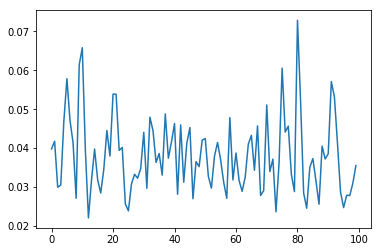

288/288 [==============================] - 30s - loss: 0.0355 - val_loss: 0.1161
Epoch 101/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0358

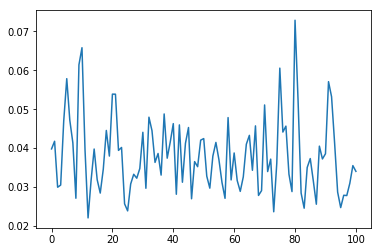

288/288 [==============================] - 30s - loss: 0.0340 - val_loss: 0.2692
Epoch 102/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0380

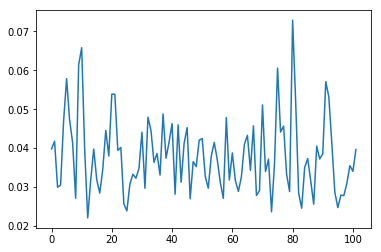

288/288 [==============================] - 29s - loss: 0.0396 - val_loss: 0.1790
Epoch 103/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0378

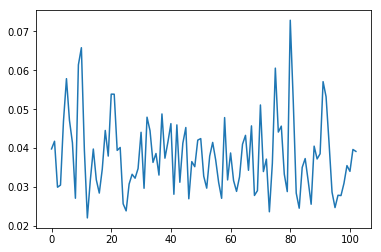

288/288 [==============================] - 32s - loss: 0.0391 - val_loss: 0.2237
Epoch 104/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0395

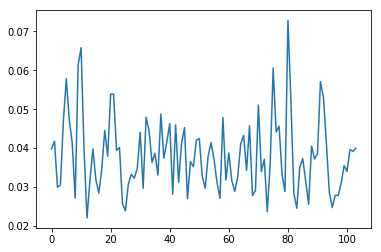

288/288 [==============================] - 29s - loss: 0.0400 - val_loss: 0.1973
Epoch 105/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0403

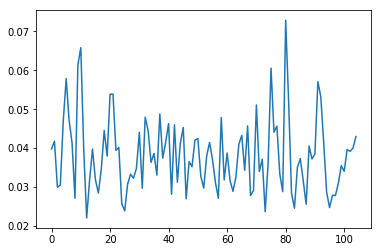

288/288 [==============================] - 30s - loss: 0.0430 - val_loss: 0.1171
Epoch 106/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0315

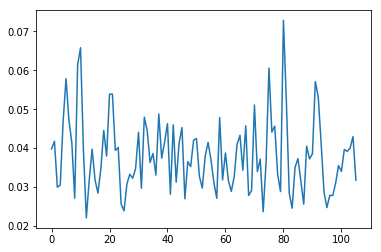

288/288 [==============================] - 29s - loss: 0.0318 - val_loss: 0.0943
Epoch 107/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0312

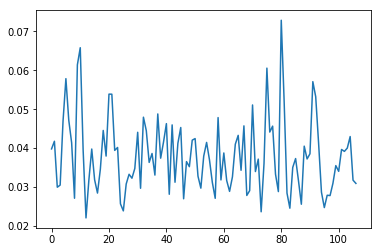

288/288 [==============================] - 29s - loss: 0.0309 - val_loss: 0.1111
Epoch 108/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0402

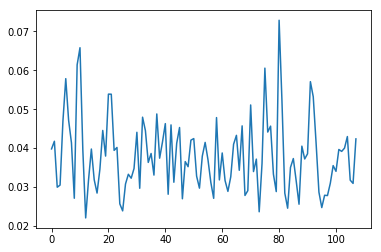

288/288 [==============================] - 29s - loss: 0.0424 - val_loss: 0.0778
Epoch 109/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0375

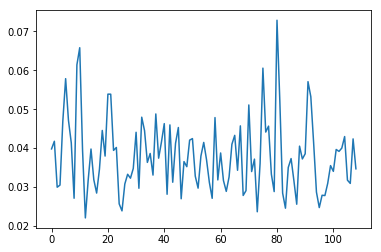

288/288 [==============================] - 30s - loss: 0.0347 - val_loss: 0.3394
Epoch 110/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0514

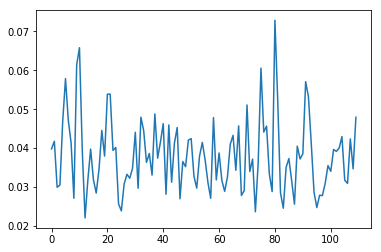

288/288 [==============================] - 30s - loss: 0.0479 - val_loss: 0.1333
Epoch 111/466
240/288 [========================>.....] - ETA: 5s - loss: 0.0299 

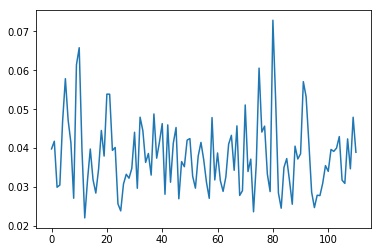

288/288 [==============================] - 33s - loss: 0.0389 - val_loss: 0.0549
Epoch 112/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0385

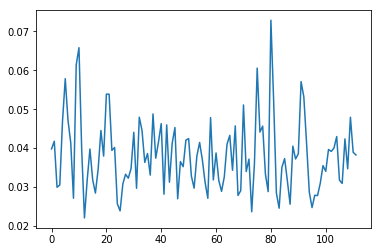

288/288 [==============================] - 30s - loss: 0.0382 - val_loss: 0.2221
Epoch 113/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0341

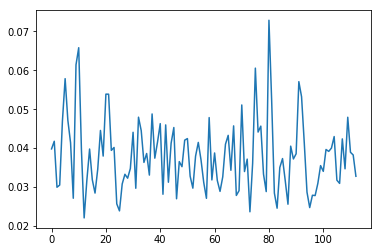

288/288 [==============================] - 30s - loss: 0.0328 - val_loss: 0.2496
Epoch 114/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0416

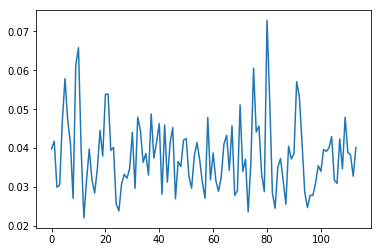

288/288 [==============================] - 32s - loss: 0.0402 - val_loss: 0.2513
Epoch 115/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0304

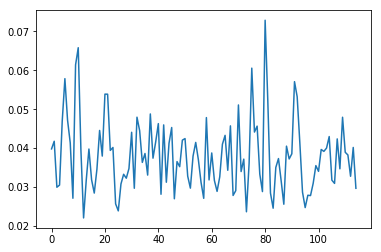

288/288 [==============================] - 31s - loss: 0.0297 - val_loss: 0.4663
Epoch 116/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0422 

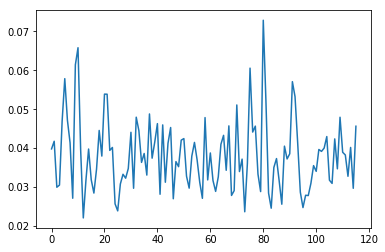

288/288 [==============================] - 33s - loss: 0.0456 - val_loss: 0.1095
Epoch 117/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0351

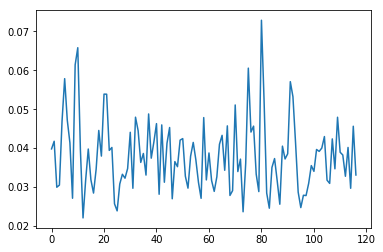

288/288 [==============================] - 34s - loss: 0.0331 - val_loss: 0.0410
Epoch 118/466
240/288 [========================>.....] - ETA: 6s - loss: 0.0280 

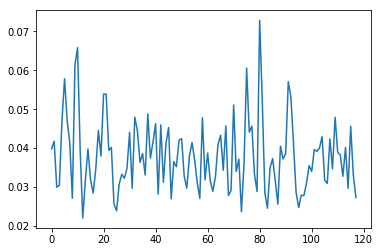

288/288 [==============================] - 42s - loss: 0.0273 - val_loss: 0.2425
Epoch 119/466
240/288 [========================>.....] - ETA: 7s - loss: 0.0399 

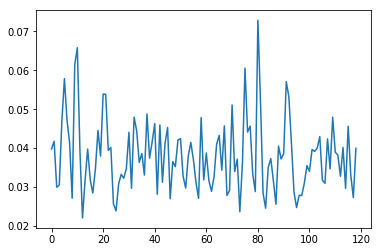

288/288 [==============================] - 47s - loss: 0.0399 - val_loss: 0.0692
Epoch 120/466
240/288 [========================>.....] - ETA: 6s - loss: 0.0429 

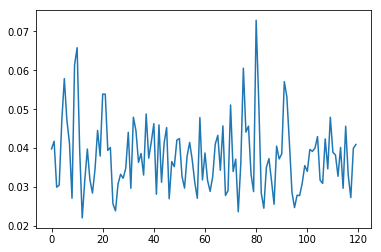

288/288 [==============================] - 42s - loss: 0.0409 - val_loss: 0.1856
Epoch 121/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0315

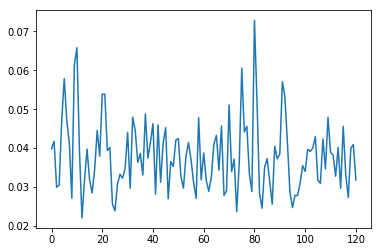

288/288 [==============================] - 44s - loss: 0.0318 - val_loss: 0.0899
Epoch 122/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0497

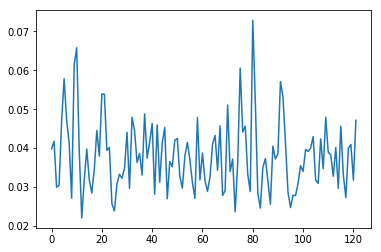

288/288 [==============================] - 31s - loss: 0.0471 - val_loss: 0.2791
Epoch 123/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0264

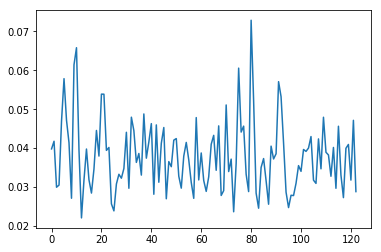

288/288 [==============================] - 32s - loss: 0.0288 - val_loss: 0.2851
Epoch 124/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0277

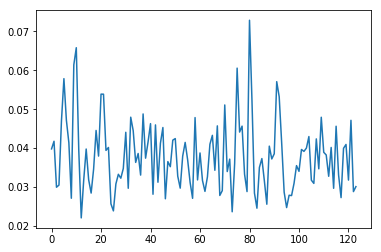

288/288 [==============================] - 32s - loss: 0.0301 - val_loss: 0.1927
Epoch 125/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0357

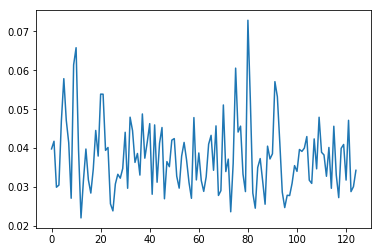

288/288 [==============================] - 31s - loss: 0.0343 - val_loss: 0.0613
Epoch 126/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0403

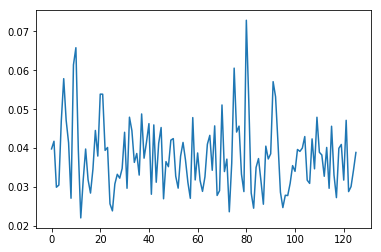

288/288 [==============================] - 31s - loss: 0.0389 - val_loss: 0.1171
Epoch 127/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0321

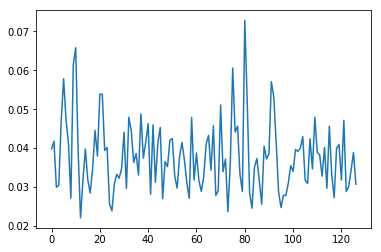

288/288 [==============================] - 33s - loss: 0.0307 - val_loss: 0.1960
Epoch 128/466
240/288 [========================>.....] - ETA: 5s - loss: 0.0294 

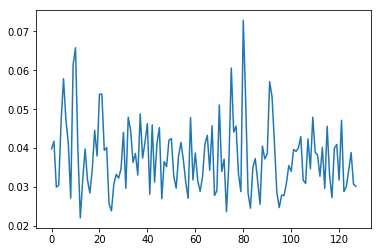

288/288 [==============================] - 34s - loss: 0.0302 - val_loss: 0.0462
Epoch 129/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0301

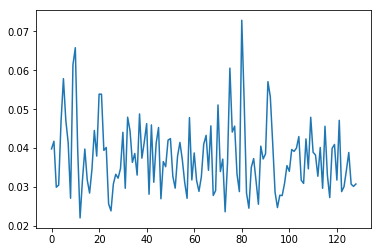

288/288 [==============================] - 31s - loss: 0.0308 - val_loss: 0.1645
Epoch 130/466
240/288 [========================>.....] - ETA: 5s - loss: 0.0461 

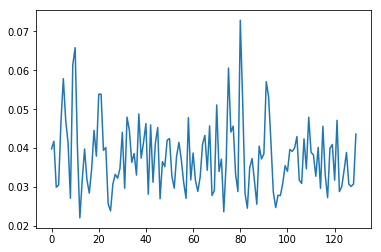

288/288 [==============================] - 34s - loss: 0.0436 - val_loss: 0.1652
Epoch 131/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0301

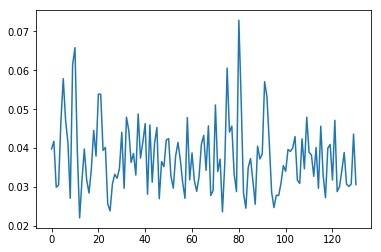

288/288 [==============================] - 31s - loss: 0.0306 - val_loss: 0.0793
Epoch 132/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0373

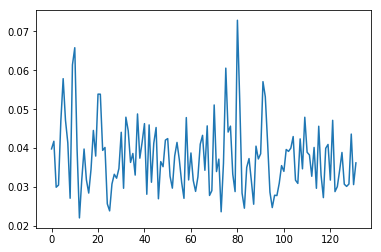

288/288 [==============================] - 31s - loss: 0.0362 - val_loss: 0.1155
Epoch 133/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0333

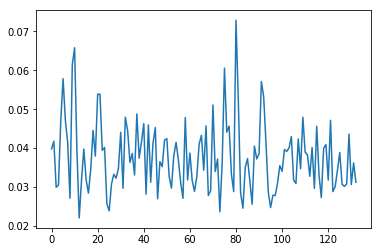

288/288 [==============================] - 31s - loss: 0.0312 - val_loss: 0.4098
Epoch 134/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0319

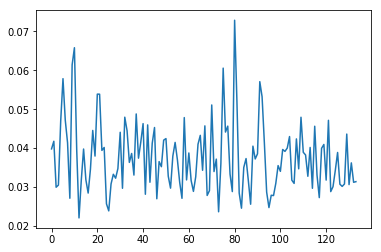

288/288 [==============================] - 30s - loss: 0.0314 - val_loss: 0.1071
Epoch 135/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0380

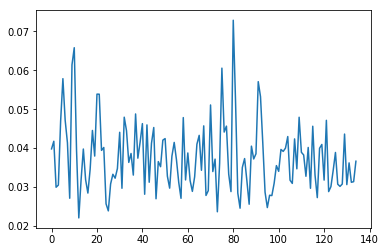

288/288 [==============================] - 31s - loss: 0.0366 - val_loss: 0.0321
Epoch 136/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0351

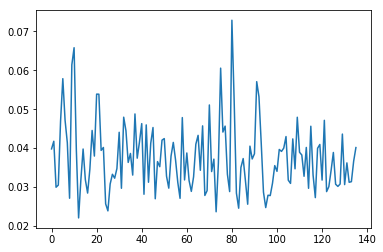

288/288 [==============================] - 33s - loss: 0.0401 - val_loss: 0.1306
Epoch 137/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0413

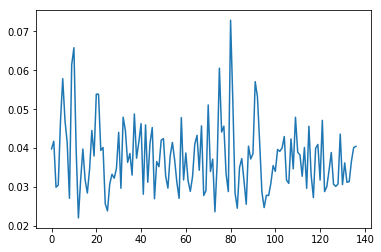

288/288 [==============================] - 31s - loss: 0.0404 - val_loss: 0.1603
Epoch 138/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0314

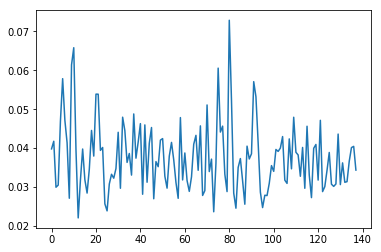

288/288 [==============================] - 31s - loss: 0.0343 - val_loss: 0.2267
Epoch 139/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0461

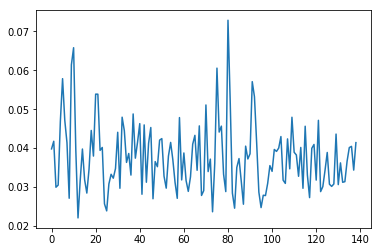

288/288 [==============================] - 30s - loss: 0.0414 - val_loss: 0.1628
Epoch 140/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0220

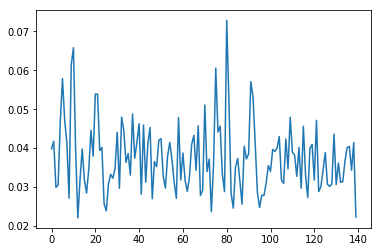

288/288 [==============================] - 30s - loss: 0.0223 - val_loss: 0.0908
Epoch 141/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0531

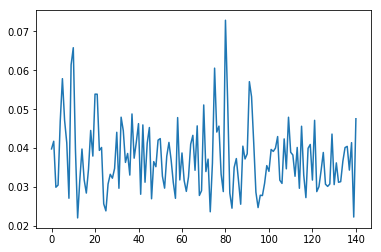

288/288 [==============================] - 29s - loss: 0.0475 - val_loss: 0.0653
Epoch 142/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0382

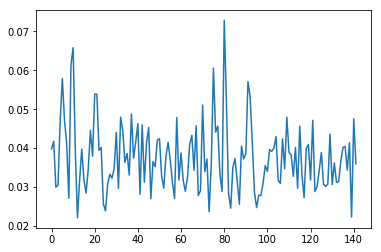

288/288 [==============================] - 30s - loss: 0.0360 - val_loss: 0.0298
Epoch 143/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0376

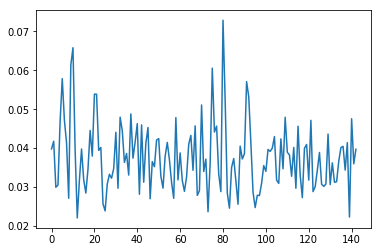

288/288 [==============================] - 29s - loss: 0.0397 - val_loss: 0.2792
Epoch 144/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0280

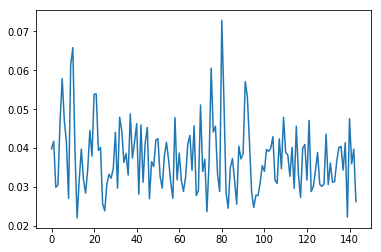

288/288 [==============================] - 30s - loss: 0.0263 - val_loss: 0.0908
Epoch 145/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0240

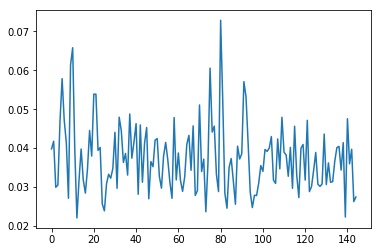

288/288 [==============================] - 30s - loss: 0.0274 - val_loss: 0.1961
Epoch 146/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0491

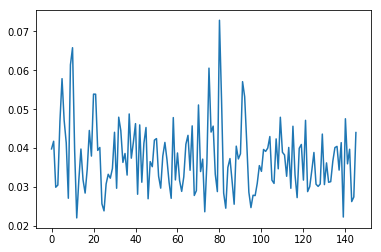

288/288 [==============================] - 29s - loss: 0.0440 - val_loss: 0.0337
Epoch 147/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0597

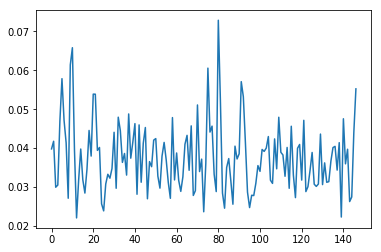

288/288 [==============================] - 30s - loss: 0.0552 - val_loss: 0.0664
Epoch 148/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0399

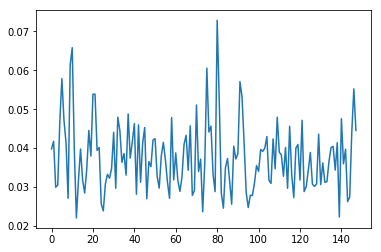

288/288 [==============================] - 29s - loss: 0.0445 - val_loss: 0.0586
Epoch 149/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0387

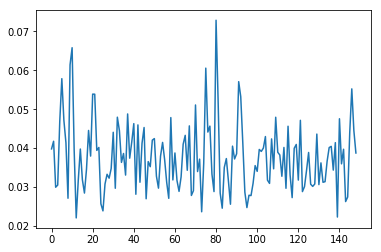

288/288 [==============================] - 31s - loss: 0.0387 - val_loss: 0.2481
Epoch 150/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0275

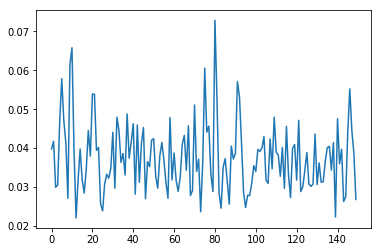

288/288 [==============================] - 31s - loss: 0.0268 - val_loss: 0.1001
Epoch 151/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0641

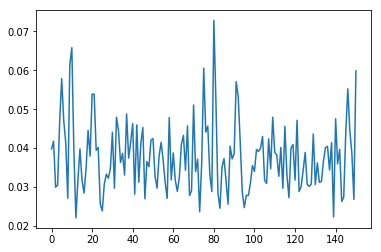

288/288 [==============================] - 29s - loss: 0.0599 - val_loss: 0.1238
Epoch 152/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0489

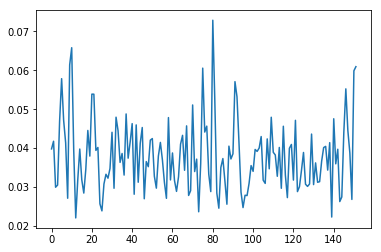

288/288 [==============================] - 30s - loss: 0.0609 - val_loss: 0.2975
Epoch 153/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0423

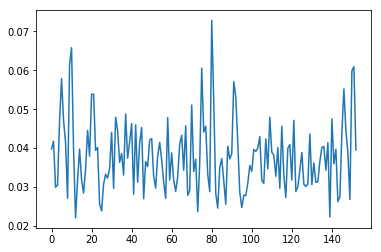

288/288 [==============================] - 29s - loss: 0.0396 - val_loss: 0.0697
Epoch 154/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0237

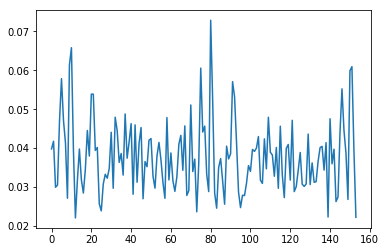

288/288 [==============================] - 29s - loss: 0.0222 - val_loss: 0.2350
Epoch 155/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0297

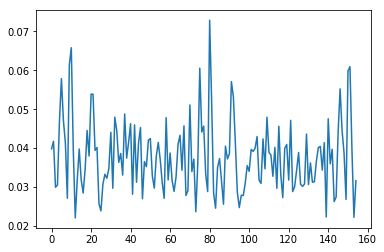

288/288 [==============================] - 30s - loss: 0.0316 - val_loss: 0.1709
Epoch 156/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0367

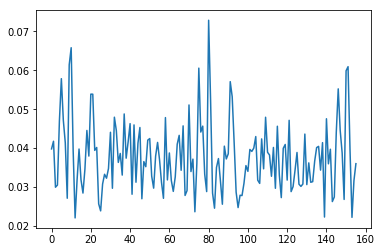

288/288 [==============================] - 29s - loss: 0.0360 - val_loss: 0.0834
Epoch 157/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0332

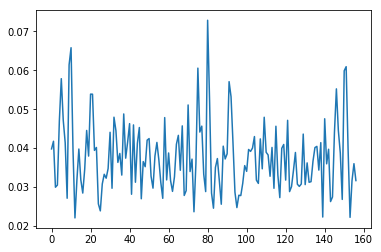

288/288 [==============================] - 30s - loss: 0.0316 - val_loss: 0.2830
Epoch 158/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0301

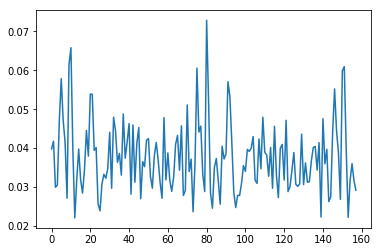

288/288 [==============================] - 29s - loss: 0.0292 - val_loss: 0.0833
Epoch 159/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0309

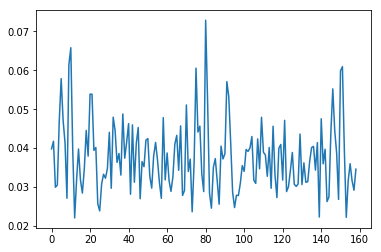

288/288 [==============================] - 30s - loss: 0.0346 - val_loss: 0.0682
Epoch 160/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0407

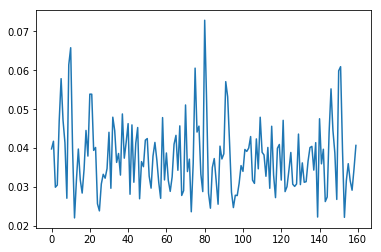

288/288 [==============================] - 29s - loss: 0.0407 - val_loss: 0.2549
Epoch 161/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0306

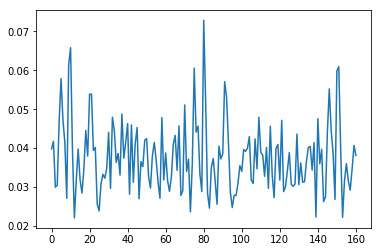

288/288 [==============================] - 29s - loss: 0.0381 - val_loss: 0.1022
Epoch 162/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0346

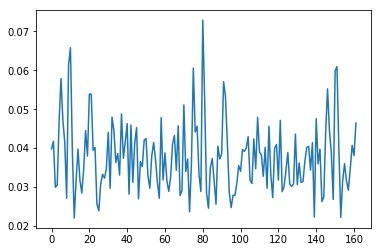

288/288 [==============================] - 30s - loss: 0.0464 - val_loss: 0.0570
Epoch 163/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0594

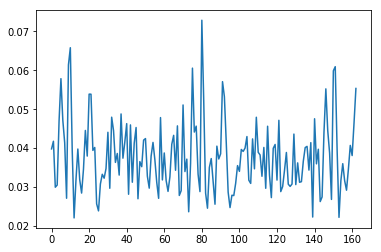

288/288 [==============================] - 30s - loss: 0.0553 - val_loss: 0.1072
Epoch 164/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0353

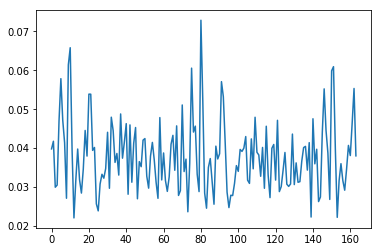

288/288 [==============================] - 29s - loss: 0.0380 - val_loss: 0.1634
Epoch 165/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0342

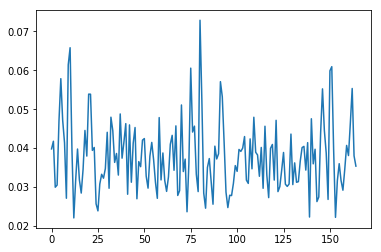

288/288 [==============================] - 30s - loss: 0.0354 - val_loss: 0.2304
Epoch 166/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0234

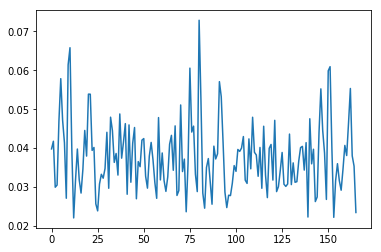

288/288 [==============================] - 30s - loss: 0.0234 - val_loss: 0.3821
Epoch 167/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0239

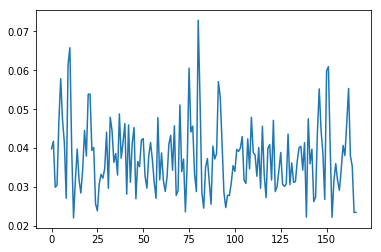

288/288 [==============================] - 29s - loss: 0.0235 - val_loss: 0.1097
Epoch 168/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0310

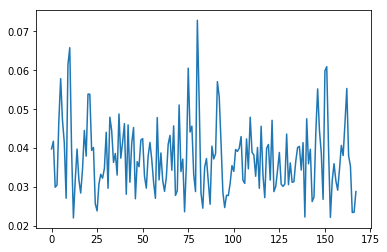

288/288 [==============================] - 30s - loss: 0.0288 - val_loss: 0.0383
Epoch 169/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0258

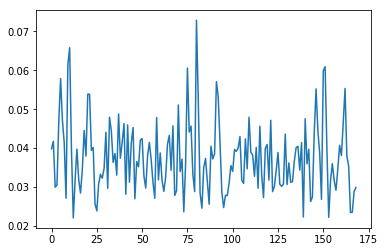

288/288 [==============================] - 30s - loss: 0.0299 - val_loss: 0.0712
Epoch 170/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0258

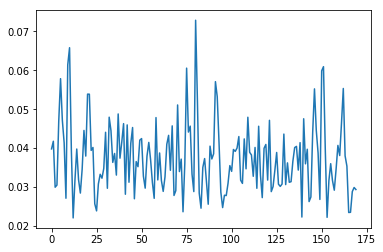

288/288 [==============================] - 30s - loss: 0.0293 - val_loss: 0.0998
Epoch 171/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0341

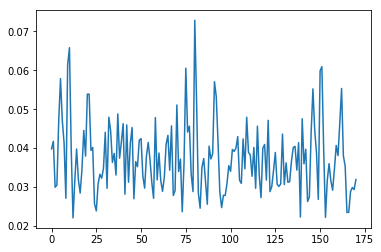

288/288 [==============================] - 29s - loss: 0.0319 - val_loss: 0.3061
Epoch 172/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0418

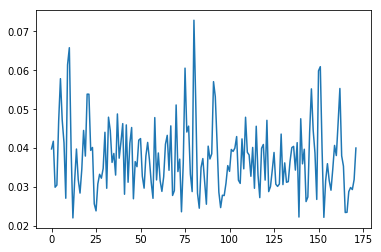

288/288 [==============================] - 30s - loss: 0.0400 - val_loss: 0.2340
Epoch 173/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0309

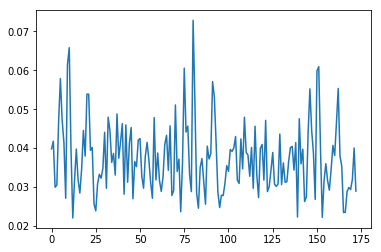

288/288 [==============================] - 29s - loss: 0.0289 - val_loss: 0.0611
Epoch 174/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0483

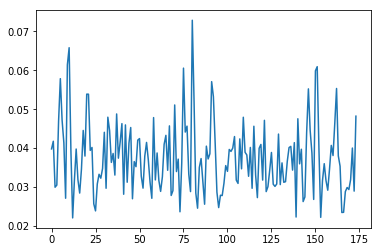

288/288 [==============================] - 30s - loss: 0.0482 - val_loss: 0.0440
Epoch 175/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0427

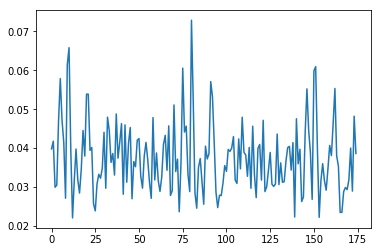

288/288 [==============================] - 29s - loss: 0.0386 - val_loss: 0.0292
Epoch 176/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0340

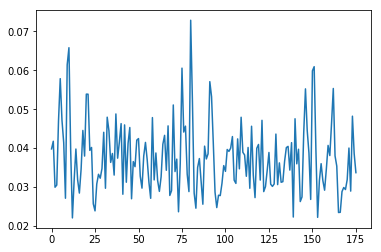

288/288 [==============================] - 31s - loss: 0.0337 - val_loss: 0.2628
Epoch 177/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0340

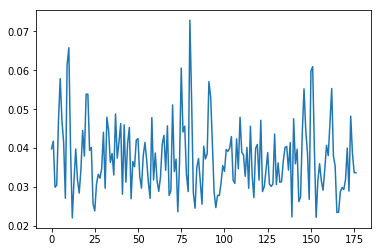

288/288 [==============================] - 31s - loss: 0.0337 - val_loss: 0.1211
Epoch 178/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0293

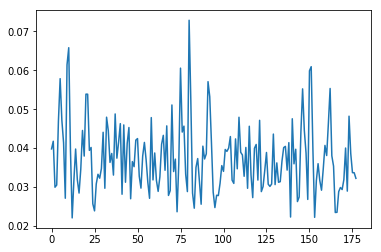

288/288 [==============================] - 31s - loss: 0.0322 - val_loss: 0.0512
Epoch 179/466
240/288 [========================>.....] - ETA: 5s - loss: 0.0490 

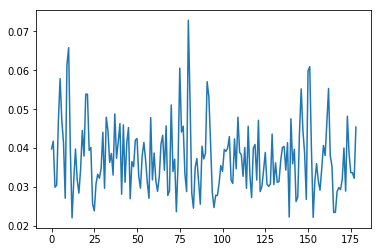

288/288 [==============================] - 33s - loss: 0.0454 - val_loss: 0.0621
Epoch 180/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0341

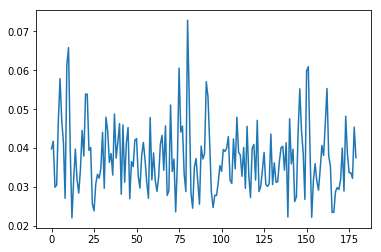

288/288 [==============================] - 31s - loss: 0.0375 - val_loss: 0.2772
Epoch 181/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0386

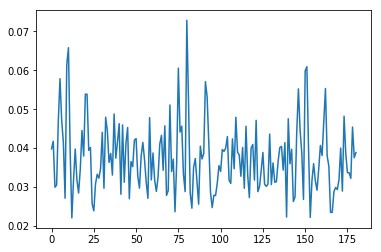

288/288 [==============================] - 30s - loss: 0.0388 - val_loss: 0.2851
Epoch 182/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0507

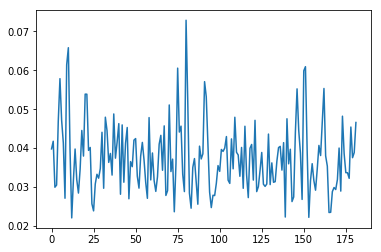

288/288 [==============================] - 30s - loss: 0.0466 - val_loss: 0.0305
Epoch 183/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0293

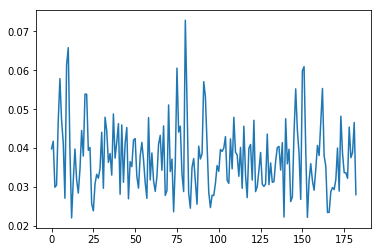

288/288 [==============================] - 29s - loss: 0.0280 - val_loss: 0.0495
Epoch 184/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0382

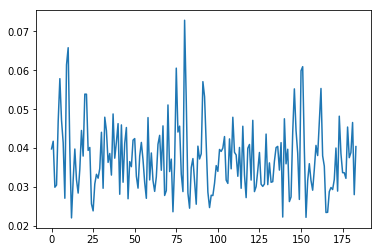

288/288 [==============================] - 30s - loss: 0.0404 - val_loss: 0.2109
Epoch 185/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0298

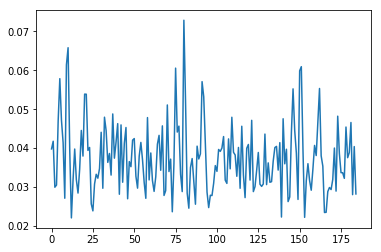

288/288 [==============================] - 29s - loss: 0.0282 - val_loss: 0.1059
Epoch 186/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0393

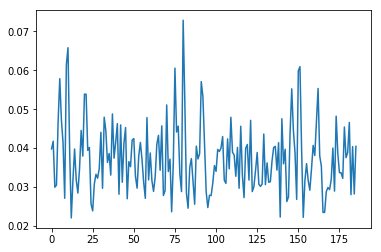

288/288 [==============================] - 30s - loss: 0.0404 - val_loss: 0.1150
Epoch 187/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0420

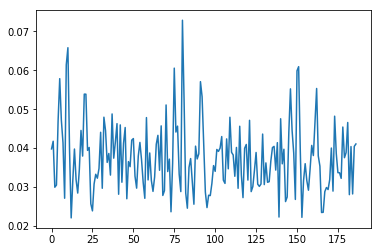

288/288 [==============================] - 30s - loss: 0.0411 - val_loss: 0.1078
Epoch 188/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0234

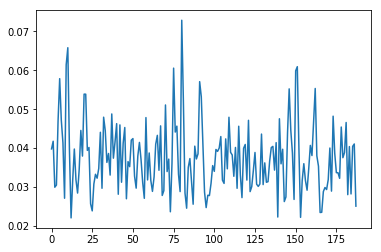

288/288 [==============================] - 30s - loss: 0.0251 - val_loss: 0.2472
Epoch 189/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0366

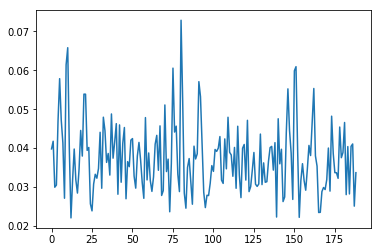

288/288 [==============================] - 30s - loss: 0.0337 - val_loss: 0.1579
Epoch 190/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0349

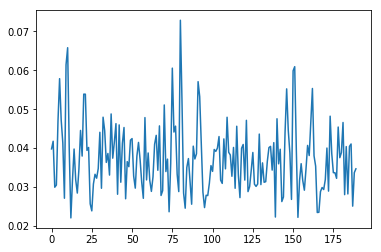

288/288 [==============================] - 30s - loss: 0.0347 - val_loss: 0.2256
Epoch 191/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0398

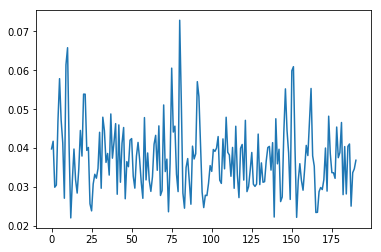

288/288 [==============================] - 29s - loss: 0.0369 - val_loss: 0.1828
Epoch 192/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0441

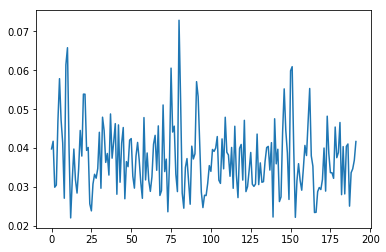

288/288 [==============================] - 30s - loss: 0.0417 - val_loss: 0.1154
Epoch 193/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0339

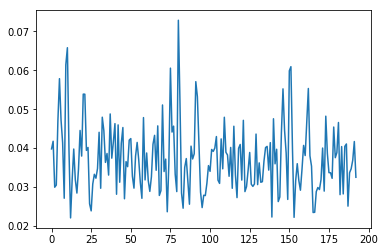

288/288 [==============================] - 29s - loss: 0.0325 - val_loss: 0.0683
Epoch 194/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0286

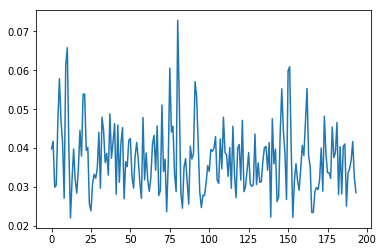

288/288 [==============================] - 30s - loss: 0.0285 - val_loss: 0.0350
Epoch 195/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0377

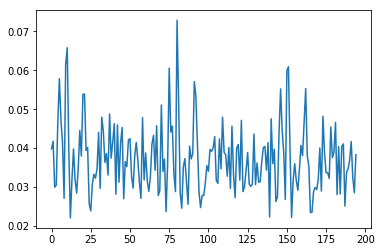

288/288 [==============================] - 29s - loss: 0.0383 - val_loss: 0.3022
Epoch 196/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0381

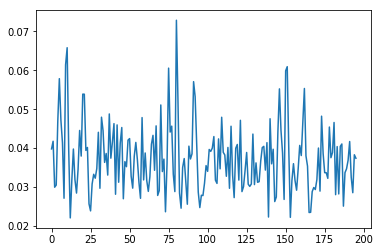

288/288 [==============================] - 30s - loss: 0.0374 - val_loss: 0.0979
Epoch 197/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0328

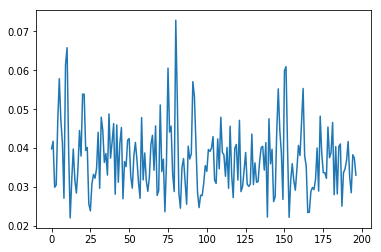

288/288 [==============================] - 31s - loss: 0.0330 - val_loss: 0.1914
Epoch 198/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0283

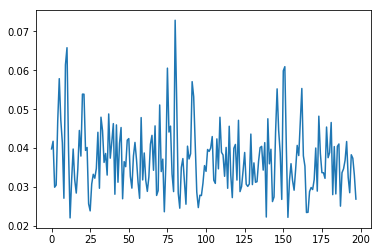

288/288 [==============================] - 31s - loss: 0.0269 - val_loss: 0.0350
Epoch 199/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0308

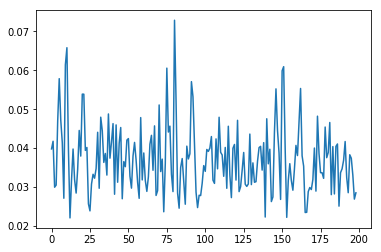

288/288 [==============================] - 30s - loss: 0.0285 - val_loss: 0.1212
Epoch 200/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0363

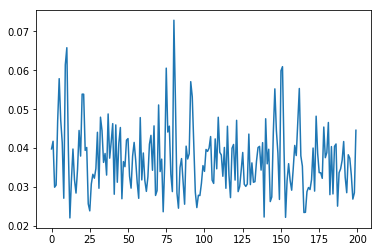

288/288 [==============================] - 31s - loss: 0.0446 - val_loss: 0.1530
Epoch 201/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0284

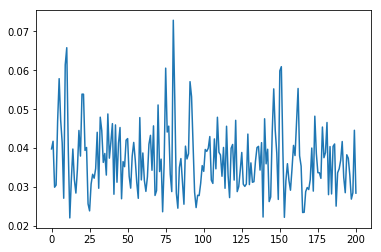

288/288 [==============================] - 31s - loss: 0.0284 - val_loss: 0.1075
Epoch 202/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0372

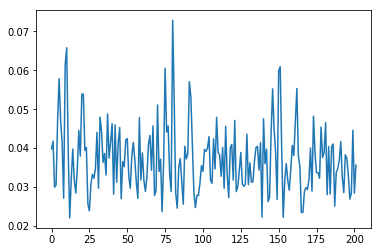

288/288 [==============================] - 31s - loss: 0.0356 - val_loss: 0.2307
Epoch 203/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0341

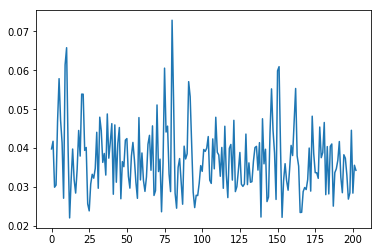

288/288 [==============================] - 31s - loss: 0.0343 - val_loss: 0.0562
Epoch 204/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0251

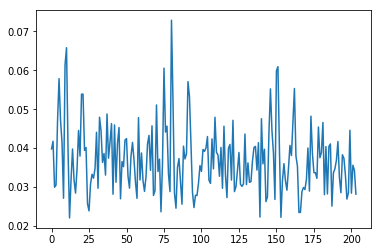

288/288 [==============================] - 32s - loss: 0.0282 - val_loss: 0.0441
Epoch 205/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0280

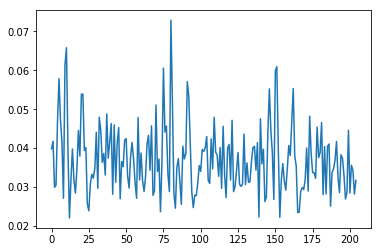

288/288 [==============================] - 43s - loss: 0.0317 - val_loss: 0.1949
Epoch 206/466
240/288 [========================>.....] - ETA: 5s - loss: 0.0392 

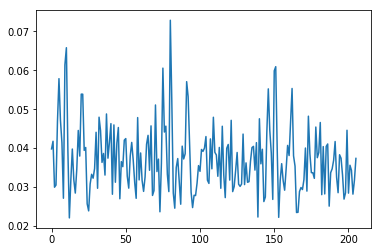

288/288 [==============================] - 34s - loss: 0.0373 - val_loss: 0.2808
Epoch 207/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0448

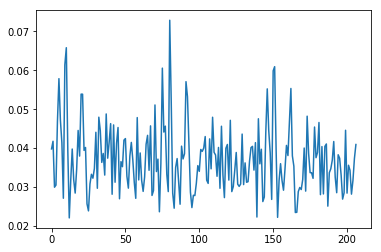

288/288 [==============================] - 33s - loss: 0.0409 - val_loss: 0.1121
Epoch 208/466
240/288 [========================>.....] - ETA: 5s - loss: 0.0345 

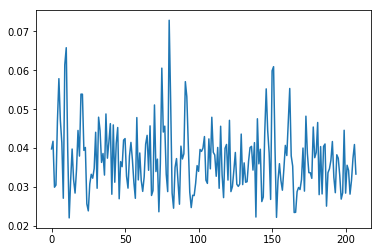

288/288 [==============================] - 35s - loss: 0.0333 - val_loss: 0.0998
Epoch 209/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0416

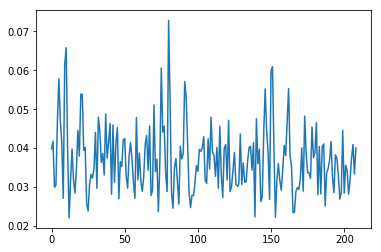

288/288 [==============================] - 34s - loss: 0.0400 - val_loss: 0.2283
Epoch 210/466
240/288 [========================>.....] - ETA: 5s - loss: 0.0277 

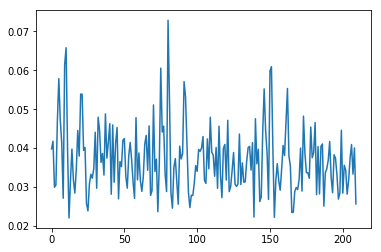

288/288 [==============================] - 35s - loss: 0.0257 - val_loss: 0.1040
Epoch 211/466
240/288 [========================>.....] - ETA: 5s - loss: 0.0259 

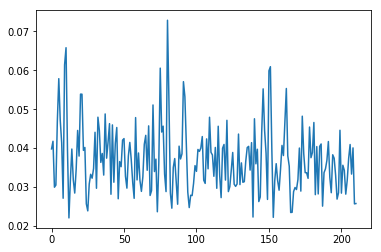

288/288 [==============================] - 35s - loss: 0.0257 - val_loss: 0.1129
Epoch 212/466
240/288 [========================>.....] - ETA: 5s - loss: 0.0538 

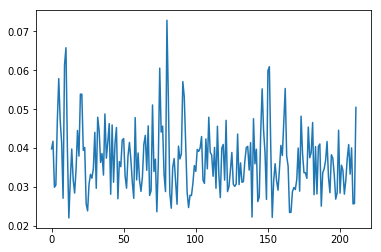

288/288 [==============================] - 38s - loss: 0.0505 - val_loss: 0.0518
Epoch 213/466
240/288 [========================>.....] - ETA: 5s - loss: 0.0342 

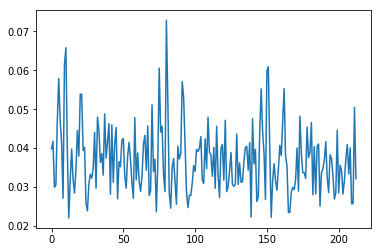

288/288 [==============================] - 37s - loss: 0.0321 - val_loss: 0.0741
Epoch 214/466
240/288 [========================>.....] - ETA: 5s - loss: 0.0344 

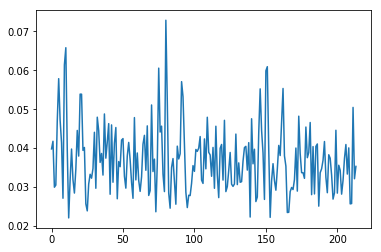

288/288 [==============================] - 37s - loss: 0.0353 - val_loss: 0.1772
Epoch 215/466
240/288 [========================>.....] - ETA: 5s - loss: 0.0222 

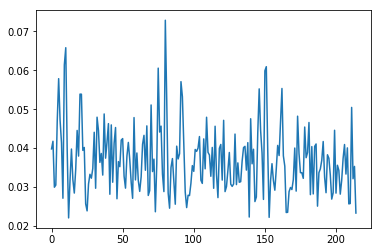

288/288 [==============================] - 41s - loss: 0.0233 - val_loss: 0.0713
Epoch 216/466
240/288 [========================>.....] - ETA: 5s - loss: 0.0364 

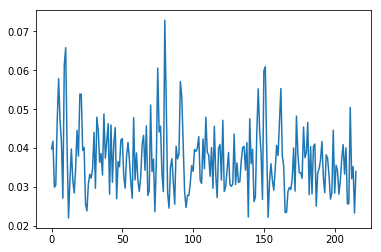

288/288 [==============================] - 36s - loss: 0.0340 - val_loss: 0.2212
Epoch 217/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0521

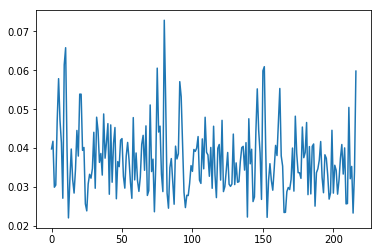

288/288 [==============================] - 32s - loss: 0.0598 - val_loss: 0.1193
Epoch 218/466
240/288 [========================>.....] - ETA: 5s - loss: 0.0418 

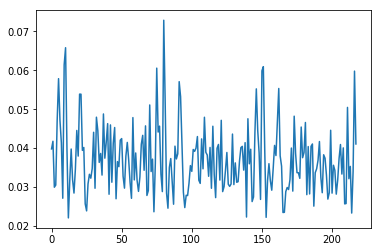

288/288 [==============================] - 37s - loss: 0.0411 - val_loss: 0.2370
Epoch 219/466
240/288 [========================>.....] - ETA: 9s - loss: 0.0486 

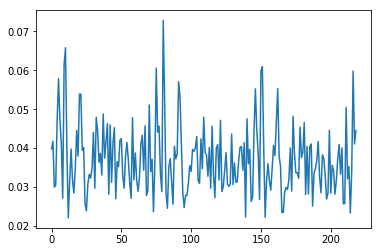

288/288 [==============================] - 64s - loss: 0.0445 - val_loss: 0.1112
Epoch 220/466
240/288 [========================>.....] - ETA: 8s - loss: 0.0341 

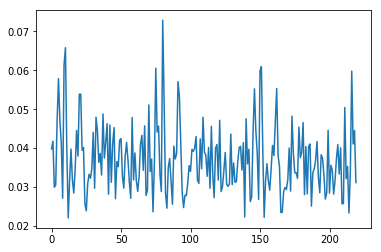

288/288 [==============================] - 51s - loss: 0.0311 - val_loss: 0.0550
Epoch 221/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0300

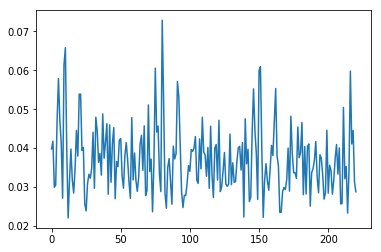

288/288 [==============================] - 33s - loss: 0.0288 - val_loss: 0.2878
Epoch 222/466
240/288 [========================>.....] - ETA: 5s - loss: 0.0759 

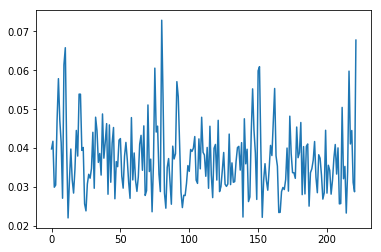

288/288 [==============================] - 37s - loss: 0.0677 - val_loss: 0.1036
Epoch 223/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0493

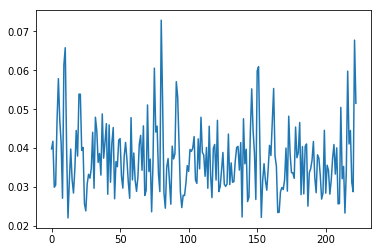

288/288 [==============================] - 32s - loss: 0.0515 - val_loss: 0.0866
Epoch 224/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0352 

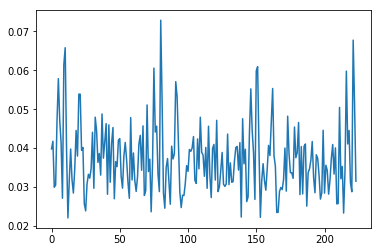

288/288 [==============================] - 33s - loss: 0.0315 - val_loss: 0.0655
Epoch 225/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0239 

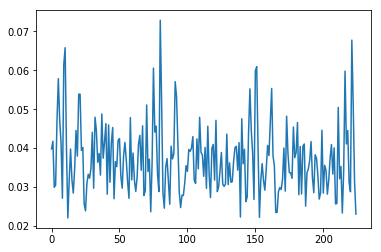

288/288 [==============================] - 33s - loss: 0.0230 - val_loss: 0.0539
Epoch 226/466
240/288 [========================>.....] - ETA: 5s - loss: 0.0315 

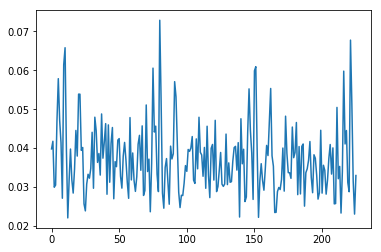

288/288 [==============================] - 37s - loss: 0.0329 - val_loss: 0.1868
Epoch 227/466
240/288 [========================>.....] - ETA: 5s - loss: 0.0360 

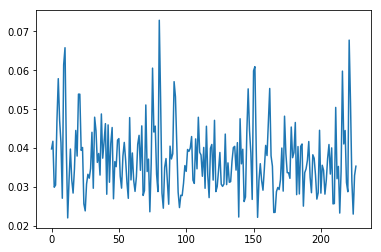

288/288 [==============================] - 36s - loss: 0.0353 - val_loss: 0.1300
Epoch 228/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0267

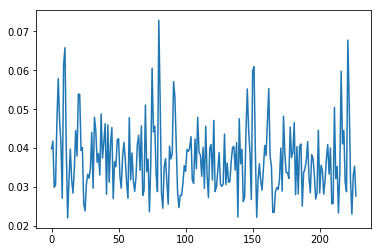

288/288 [==============================] - 33s - loss: 0.0277 - val_loss: 0.1171
Epoch 229/466
240/288 [========================>.....] - ETA: 5s - loss: 0.0250 

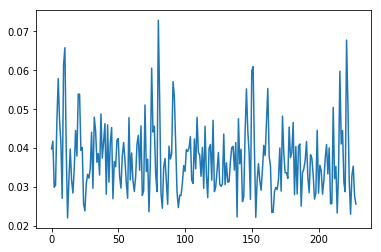

288/288 [==============================] - 35s - loss: 0.0256 - val_loss: 0.0819
Epoch 230/466
240/288 [========================>.....] - ETA: 4s - loss: 0.0343

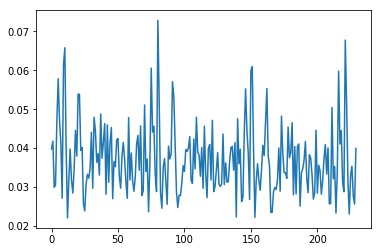

288/288 [==============================] - 33s - loss: 0.0399 - val_loss: 0.2778
Epoch 231/466
240/288 [========================>.....] - ETA: 5s - loss: 0.0299 

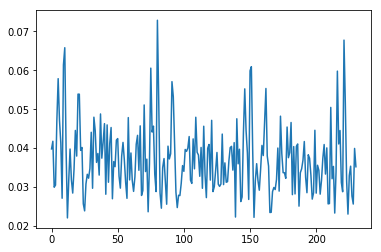

288/288 [==============================] - 35s - loss: 0.0352 - val_loss: 0.1083
Epoch 232/466
240/288 [========================>.....] - ETA: 5s - loss: 0.0349 

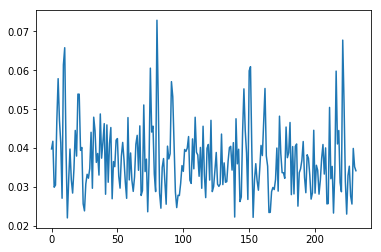

288/288 [==============================] - 35s - loss: 0.0342 - val_loss: 0.1601
Epoch 233/466
240/288 [========================>.....] - ETA: 5s - loss: 0.0518 

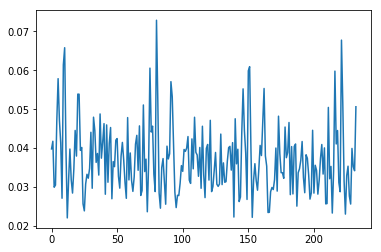

288/288 [==============================] - 40s - loss: 0.0506 - val_loss: 0.0501
Epoch 234/466
240/288 [========================>.....] - ETA: 5s - loss: 0.0498 

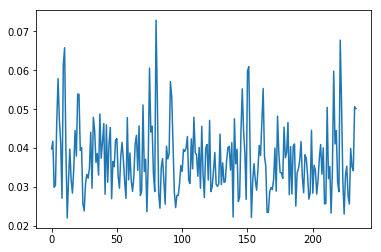

288/288 [==============================] - 39s - loss: 0.0501 - val_loss: 0.2029
Epoch 235/466
240/288 [========================>.....] - ETA: 5s - loss: 0.0363 

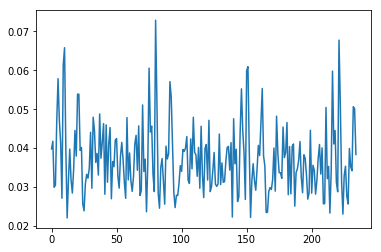

288/288 [==============================] - 37s - loss: 0.0383 - val_loss: 0.1172

In [ ]:
from keras.models import Sequential,load_model
from keras.layers.core import Dense, Activation, Dropout, Reshape, Flatten, Lambda
from keras.layers.convolutional import Convolution2D, Cropping2D, SeparableConv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Merge
from keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback

import tensorflow as tf


# Hyperparameter Compile
loss= 'mse' # 'hinge'
optimizer= 'Nadam' #'Nadam' #'rmsprop'
# Hyperparameter Fit
rounds = 5
n_batches = len(df)//batch_size_single

nb_epoch= n_batches * rounds
batch_size = batch_size_single * 6
patience=5000

print('nb_epoch   \t: {:>5}'.format(nb_epoch))
print('batch_size \t: {:>5}'.format(batch_size))
print('patience   \t: {:>5}'.format(patience))

def model():
    model = Sequential()
    model.add(Cropping2D(cropping=((65,23), (0,0)), input_shape=image_shape)) #23
    #model.add(Lambda(lambda x: (x[:,:,:,0:1]+x[:,:,:,1:2]+x[:,:,:,2:3])/3)) ## drive on gray
    model.add(Lambda(lambda x: x/127.5 - 1.))
    output_shape = ((model.layers[-1].output_shape))
    model.add(Reshape((output_shape[1]*2,int(output_shape[2]/2),output_shape[3],)))
    a = 4
    model.add(Convolution2D(2**(a+0), 9, 9, subsample=(2, 2), border_mode="same", activation = 'elu'))
    model.add(Convolution2D(2**(a+1), 7, 7, subsample=(2, 2), border_mode="same", activation = 'elu'))
    model.add(Convolution2D(2**(a+2), 5, 5, subsample=(1, 1), border_mode="same", activation = 'elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(2**(a+3), 3, 3, subsample=(2, 2), border_mode="same", activation = 'elu'))
    model.add(Convolution2D(2**(a+4), 3, 3, subsample=(2, 2), border_mode="same", activation = 'elu'))
    model.add(Convolution2D(2**(a+5), 3, 3, subsample=(1, 1), border_mode="same", activation = 'elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())  
    model.add(Flatten())
    #model.add(Dropout(.66))
    model.add(Dense(4**4, activation = 'sigmoid'))
    model.add(Dense(3**3, activation = 'relu'))
    model.add(Dense(2**2, activation = 'linear'))
    model.add(Dense(1**1, activation = 'linear'))
    return model

try:
    model = load_model('model.h5')
    #model.load_weights("model.h5")
    print("load_weights done")
except:
    print("load_weights failed")
    model = model()
    print("model initialised")
model.summary()

%time model.compile(loss=loss, optimizer=optimizer)

losses = []
def plot_loss(epoch, logs):
    if(len(logs['loss'])>5):
        losses.append(logs['loss'])
        plt.plot(losses)
        plt.show()

def callbacks():
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience,verbose=0,)
    model_checkpoit = ModelCheckpoint('model.h5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
    plot_loss_callback = LambdaCallback(on_epoch_end=plot_loss)
    return [early_stopping,model_checkpoit,plot_loss_callback]

history_object = model.fit_generator(generator         = train_generator, \
                    samples_per_epoch = batch_size*6, \
                    validation_data   = validation_generator, \
                    nb_val_samples    = 1, \
                    nb_epoch          = nb_epoch,\
                    callbacks         = callbacks() \
                                    )

plot_history_object(history_object)

import winsound
winsound.Beep(130,10000)

In [ ]:
'''
https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html
'''

In [ ]:
import argparse
import base64
from datetime import datetime
import os
import shutil

import numpy as np
import socketio
import eventlet
import eventlet.wsgi
from PIL import Image
from flask import Flask
from io import BytesIO

from keras.models import load_model
import h5py
from keras import __version__ as keras_version

model = load_model('model.h5')
print("load_model done")

sio = socketio.Server()
app = Flask(__name__)
prev_image_array = None


class SimplePIController:
    def __init__(self, Kp, Ki):
        self.Kp = Kp
        self.Ki = Ki
        self.set_point = 0.
        self.error = 0.
        self.integral = 0.

    def set_desired(self, desired):
        self.set_point = desired

    def update(self, measurement):
        # proportional error
        self.error = self.set_point - measurement
        # integral error
        self.integral += self.error
        return self.Kp * self.error + self.Ki * self.integral

controller = SimplePIController(0.1, 0.002)
set_speed = 15
controller.set_desired(set_speed)

@sio.on('telemetry')
def telemetry(sid, data):
    if data:
        # The current steering angle of the car
        steering_angle = data["steering_angle"]
        # The current throttle of the car
        throttle = data["throttle"]
        # The current speed of the car
        speed = data["speed"]
        # The current image from the center camera of the car
        imgString = data["image"]
        image = Image.open(BytesIO(base64.b64decode(imgString)))
        image_array = np.asarray(image)
        steering_angle = float(model.predict(image_array[None, :, :, :], batch_size=1))
        throttle = controller.update(float(speed))
        print(steering_angle, throttle)
        send_control(steering_angle, throttle)
    else:
        # NOTE: DON'T EDIT THIS.
        sio.emit('manual', data={}, skip_sid=True)


@sio.on('connect')
def connect(sid, environ):
    print("connect ", sid)
    send_control(0, 0)

def send_control(steering_angle, throttle):
    sio.emit(
        "steer",
        data={
            'steering_angle': steering_angle.__str__(),
            'throttle': throttle.__str__()
        },
        skip_sid=True)

# wrap Flask application with engineio's middleware
app = socketio.Middleware(sio, app)

# deploy as an eventlet WSGI server
eventlet.wsgi.server(eventlet.listen(('', 4567)), app)
